## Comparing Demand Forecasting Models: From Naive to Deep Learning

### Introduction
This project focuses on forecasting weekly product demand across different SKUs (product × region × channel).
Using a mix of statistical, classic machine learning, and deep learning models, we compare forecasting performance and identify the best approaches for different types of demand patterns.
The goal is to build accurate, scalable, and interpretable models that can support real-world planning and inventory decisions.

### Project Goals
- Build a demand forecasting pipeline using engineered features like lags, promotions, seasonality, and product age
- Train, tune, and evaluate a range of models from statistical to deep learning approaches
- Improve model accuracy through hyperparameter tuning and interpretability with SHAP
- Compare model performance across different SKUs (SKU represents a unique combination of product, region, and channel)
- Identify the most effective forecasting strategies for real-world deployment  

### Table of Contents:

1. **Statistical Models** – Naive Forecast, GLM, ARIMA/SARIMA  
2. **Traditional Machine Learning** – Ridge, Lasso, ElasticNet, LightGBM (Vanilla → Regularized → Tuned)  
3. **Deep Learning Models** – LSTM, CNN
4. **Segment-level Model Performance** - With Best Performing Model   

### Importing Python Modules

In [2]:
# General Setup
import os
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Model Saving & Export
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Regression Models (Linear, Regularized)
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LassoCV, PoissonRegressor

# Metrics & Evaluation
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    root_mean_squared_error, mean_absolute_percentage_error
)

# Time Series Models (ARIMA, SARIMAX)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf

# Feature Multicollinearity (VIF)
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Tree-Based Models (LightGBM)
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# Explainability (SHAP)
import shap

# Neural Networks (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Conv1D, Flatten, Dropout,
    GlobalMaxPooling1D, BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Loading the Data

We load multiple versions of the dataset at different preprocessing stages. Each version supports a specific modeling or analysis step in the pipeline.

In [3]:
# Load semi-processed data
train_featured_raw = pd.read_parquet("../data/train_featured_raw.parquet")
test_featured_raw = pd.read_parquet("../data/test_featured_raw.parquet")

train_featured_start = pd.read_parquet("../data/train_featured_start.parquet")
test_featured_start = pd.read_parquet("../data/test_featured_start.parquet")

train_encoded = pd.read_parquet("../data/train_encoded.parquet")
test_encoded = pd.read_parquet("../data/test_encoded.parquet")

train_reduced = pd.read_parquet("../data/train_reduced.parquet")
test_reduced = pd.read_parquet("../data/test_reduced.parquet")

print('Train - featured:', train_featured_raw.shape)
print('Test - featured:', test_featured_raw.shape)
print('Train - skew handled:', train_featured_start.shape)
print('Test - skew handled:', test_featured_start.shape)
print('Train - encoded:', train_encoded.shape)
print('Test - encoded:', test_encoded.shape)
print('Train - reduced:', train_reduced.shape)
print('Test - reduced:', test_reduced.shape)

Train - featured: (27900, 42)
Test - featured: (3600, 42)
Train - skew handled: (27900, 43)
Test - skew handled: (3600, 43)
Train - encoded: (27900, 52)
Test - encoded: (3600, 52)
Train - reduced: (27900, 41)
Test - reduced: (3600, 42)


Let's see the type of columns of the most used datasets:

<details>
<summary><strong> Feature Groups – train_encoded</strong></summary>

- **`id_cols`**: `['Pseudo_SKU_ID', 'Product_ID']`  
- **`target_col`**: `'Units_Sold_Log'`  
- **`date_col`**: `['Date']`  
- **`encoded_cat_cols`**: `['Brand_FE', 'Category_FE', 'Name_FE', 'Demand_Cluster']`  
- **`bool_cols`**: `['Promotion_Flag', 'Is_New_Launch', 'Is_Holiday_Season', 'Is_MidYear_Lift', 'Cruelty_Free']`  
- **`numeric_cols`**:  
  `['Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',  
   'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',  
   'Price_Promo_Interaction', 'Time_Since_Launch', 'Promo_Lift',  
   'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',  
   'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',  
   'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos',  
   'Week_Num', 'Week_Index', 'Month', 'Quarter']`  
- **`cat_cols`**:  
  `['Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage',  
   'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']`
  
</details>

<details>
<summary><strong> Feature Groups – train_reduced</strong></summary>

- **`id_cols`**: `['Pseudo_SKU_ID', 'Product_ID']`  
- **`target_col`**: `'Units_Sold_Log'`  
- **`date_col`**: `['Date']`  
- **`encoded_bool_cols`**: `['Promotion_Flag', 'Is_New_Launch', 'Is_Holiday_Season', 'Is_MidYear_Lift', 'Cruelty_Free']`  
- **`encoded_cat_cols`**: `['Brand_FE', 'Category_FE', 'Name_FE']`  
- **`cat_cols`**: `['Region', 'Channel', 'Skin_Type', 'Gender_Target', 'Country_of_Origin']`  
- **`num_cols`**:  
  `['Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',  
   'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',  
   'Price_Promo_Interaction', 'Time_Since_Launch',  
   'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',  
   'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',  
   'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos']`

</details>


## <span style="color:blue">I. BASELINE AND STATISTICAL TIME SERIES MODELS</span>

### 1. Naive Baseline Model

In this section, we evaluate a simple baseline where each week's demand is predicted as equal to the previous week's (Lag-1).
We apply this logic to selected SKUs and calculate basic error metrics (MAE, RMSE, MAPE, R²) to set a performance benchmark for more advanced models.

In [4]:
# Filtering and Sorting the Series
sku_ids = ['4_US_eCommerce', '29_China_Retail', '7_US_Retail', '25_EU_eCommerce']
results = []

for sku_id in sku_ids:
    # 1. Filtering and sorting by time
    sku_df = test_featured_raw[test_featured_raw['Pseudo_SKU_ID'] == sku_id]
    sku_df = sku_df.sort_values('Week_Index')

    # 2. Target series
    y_series = sku_df['Units_Sold'].reset_index(drop=True)

    # 3. Naive prediction: shift by 1 week
    y_pred_naive = y_series.shift(1)
    y_actual = y_series[1:]
    y_pred_naive = y_pred_naive[1:]

    # 4. Skip if not enough data
    if len(y_actual) < 2:
        print(f"\n Not enough data for {sku_id}")
        continue

    # Calculate metrics
    mae = mean_absolute_error(y_actual, y_pred_naive)
    rmse = root_mean_squared_error(y_actual, y_pred_naive)
    mape = mean_absolute_percentage_error(y_actual, y_pred_naive)
    r2 = r2_score(y_actual, y_pred_naive)

    # Metric results
    results.append({
            'SKU_ID': sku_id,
            'RMSE': round(rmse, 2),
            'MAE': round(mae, 2),
            'MAPE': round(mape, 4),
            'R²': round(r2, 4)
        })

# Display as DataFrame
naive_metrics_df = pd.DataFrame(results)
display(naive_metrics_df)

SKU_ID   RMSE    MAE    MAPE      R²
0   4_US_eCommerce   3.58   2.82  0.0832  0.0520
1  29_China_Retail  28.66  20.82  0.1555  0.1422
2      7_US_Retail  32.96  25.91  0.0945  0.1302
3  25_EU_eCommerce  35.60  26.55  0.0521  0.1151

In [5]:
# Merge cluster info with metrics
naive_metrics_df = naive_metrics_df.merge(
    test_featured_raw[['Pseudo_SKU_ID', 'Demand_Label']].drop_duplicates(),
    left_on='SKU_ID', right_on='Pseudo_SKU_ID',
    how='left'
)

In [6]:
naive_metrics_df[['Pseudo_SKU_ID', 'Demand_Label', 'MAPE', 'RMSE', 'R²']].sort_values('Demand_Label')

Pseudo_SKU_ID                        Demand_Label    MAPE   RMSE      R²
2      7_US_Retail              High Demand / Volatile  0.0945  32.96  0.1302
0   4_US_eCommerce                 Low Demand / Stable  0.0832   3.58  0.0520
1  29_China_Retail              Medium Demand / Stable  0.1555  28.66  0.1422
3  25_EU_eCommerce  Very High Demand / Highly Volatile  0.0521  35.60  0.1151

### 2. GLM (Generalized Linear Model)

#### Final Preprocessing

In [7]:
id_cols = ['Pseudo_SKU_ID', 'Product_ID']
target_col = "Units_Sold_Log"
date_col = 'Date'
num_cols = [
    'Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',
    'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',
    'Price_Promo_Interaction', 'Time_Since_Launch',
    'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',
    'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',
    'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos']

In [8]:
# Create X and y
X_train_glm_original = train_reduced.copy().drop(columns=id_cols + [target_col] + [date_col])
y_train_glm_original = train_reduced[target_col]

X_test_glm_original = test_reduced.copy().drop(columns=id_cols + [target_col] + [date_col])
y_test_glm_original = test_reduced[target_col]

dates = train_reduced[date_col]

##### *One-Hot-Encoding*

In [9]:
# One-hot encoding categoricals
cat_cols = ['Region', 'Channel', 'Skin_Type', 'Gender_Target', 'Country_of_Origin']

X_train_glm_ohe = pd.get_dummies(X_train_glm_original, columns=cat_cols, drop_first=True)
X_test_glm_ohe = pd.get_dummies(X_test_glm_original, columns=cat_cols, drop_first=True)

bool_cols = X_train_glm_ohe.select_dtypes(include='bool').columns.tolist()
X_train_glm_ohe[bool_cols] = X_train_glm_ohe[bool_cols].astype(int)
#X_train_glm_scaled.info()

##### *Correlation - Checking (VIF) and Handling*

In [10]:
num_cols = [
    'Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',
    'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w', 
    'Price_Promo_Interaction', 'Time_Since_Launch',
    'Avg_Demand_By_Brand', 'Avg_Demand_By_Category',
    'Units_Sold_Rank_Per_Product_Cat',  'Units_Sold_Rank_Per_Product_Brand',
    'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos',
    'Promo_Lift'
]

In [11]:
# Compute absolute correlation matrix
corr_matrix = X_train_glm_ohe[num_cols].corr().abs()

# Upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Extract highly correlated pairs (e.g., > 0.95)
high_corr = upper.stack().reset_index()
high_corr.columns = ['Feature_1', 'Feature_2', 'Correlation']
high_corr = high_corr[high_corr['Correlation'] > 0.95].sort_values(by='Correlation', ascending=False)

display(high_corr)

Feature_1       Feature_2  Correlation
84      Lag_1w  RollingMean_4w     0.985066
101     Lag_2w  RollingMean_4w     0.982977
82      Lag_1w          Lag_2w     0.964092
117     Lag_4w  RollingMean_4w     0.961405
233  Month_sin        Week_sin     0.957879
100     Lag_2w          Lag_4w     0.955387
239  Month_cos        Week_cos     0.950362

In [12]:
# Dropping highly correlated features (Corr)
drop_corr_cols = ["Month_sin", "Month_cos", "Lag_1w", "Lag_2w"]

X_train_glm_ohe_corr = X_train_glm_ohe.drop(columns=drop_corr_cols)
X_test_glm_ohe_corr = X_test_glm_ohe.drop(columns=drop_corr_cols)

In [13]:
# Variance Inflation Factor (VIF) - chasing multicollinearity

# Add constant for intercept
X_vif = add_constant(X_train_glm_ohe_corr)

# Calculate VIF
vif_data = [
    (X_vif.columns[i], variance_inflation_factor(X_vif.values, i))
    for i in range(X_vif.shape[1])
]

vif_df = pd.DataFrame(vif_data, columns=["Feature", "VIF"]).sort_values(by="VIF", ascending=False)

# Filter only problematic features (>10 to drop)
display(vif_df[vif_df["VIF"] > 10])

Feature         VIF
0                     const  254.116559
11           RollingMean_4w   28.957126
10                   Lag_4w   16.834807
7   Lifecycle_Stage_Encoded   11.314942

In [14]:
# Dropping highly correlated features (VIF)
drop_vif_cols = ["Quarter_sin", "Week_cos", "Lag_4w", "Time_Since_Launch"]

X_train_glm_ohe_vif = X_train_glm_ohe_corr.drop(columns=drop_vif_cols)
X_test_glm_ohe_vif = X_test_glm_ohe_corr.drop(columns=drop_vif_cols)

In [15]:
# Add constant
X_vif = add_constant(X_train_glm_ohe_vif)

# Recalculate VIF
vif_data = [
    (X_vif.columns[i], variance_inflation_factor(X_vif.values, i))
    for i in range(X_vif.shape[1])
]

vif_df = pd.DataFrame(vif_data, columns=["Feature", "VIF"])
vif_df = vif_df[vif_df["Feature"] != "const"].sort_values(by="VIF", ascending=False)

display(vif_df[vif_df["VIF"] > 5])

Feature        VIF
10                     RollingMean_4w  17.961831
8                      Demand_Cluster   8.721295
16             Avg_Demand_By_Category   7.081722
1                      Promotion_Flag   5.582583
18    Units_Sold_Rank_Per_Product_Cat   5.575723
19  Units_Sold_Rank_Per_Product_Brand   5.511730
13            Price_Promo_Interaction   5.496931

In [16]:
X_train_glm_original2 = X_train_glm_ohe_vif.copy()
X_test_glm_original2 = X_test_glm_ohe_vif.copy()
y_train_glm_original2 = y_train_glm_original.copy()
y_test_glm_original2 = y_test_glm_original.copy()

In [17]:
X_train_glm_original2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27900 entries, 0 to 27899
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Promotion_Flag                     27900 non-null  int32  
 1   Is_New_Launch                      27900 non-null  int32  
 2   Price_USD                          27900 non-null  float64
 3   Rating                             27900 non-null  float64
 4   Cruelty_Free                       27900 non-null  int32  
 5   Usage_Frequency_Encoded            27900 non-null  int64  
 6   Lifecycle_Stage_Encoded            27900 non-null  int64  
 7   Demand_Cluster                     27900 non-null  int64  
 8   Promo_Lift                         27900 non-null  float64
 9   RollingMean_4w                     27900 non-null  float64
 10  RollingStd_4w                      27900 non-null  float64
 11  Lag_Diff_1w                        27900 non-null  flo

In [18]:
num_cols_reduced = [
    'Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',
    'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',
    'Price_Promo_Interaction', 
    'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',
    'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',
   'Week_sin', 'Quarter_cos']

##### *Cross-Validation Strategy: TimeSeriesSplit*

In [19]:
# Setup scaler and TSCV
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()
rmse_scores = []

# TimeSeriesSplit loop
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_glm_original2)):
    print(f"\n--- Fold {fold + 1} ---")

    X_train_fold = X_train_glm_original2.iloc[train_idx].copy()
    X_val_fold   = X_train_glm_original2.iloc[val_idx].copy()
    y_train_fold = y_train_glm_original2.iloc[train_idx]
    y_val_fold   = y_train_glm_original2.iloc[val_idx]

    # Scale numerics
    X_train_fold[num_cols_reduced] = scaler.fit_transform(X_train_fold[num_cols_reduced])
    X_val_fold[num_cols_reduced] = scaler.transform(X_val_fold[num_cols_reduced])

    # Fit model
    model = PoissonRegressor(alpha=0.1, max_iter=300)
    model.fit(X_train_fold, y_train_fold)

    # Evaluate
    y_pred = model.predict(X_val_fold)
    rmse = root_mean_squared_error(y_val_fold, y_pred)
    rmse_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")


--- Fold 1 ---


  File "C:\Users\veszt\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Fold 1 RMSE: 0.3743

--- Fold 2 ---
Fold 2 RMSE: 1.1590

--- Fold 3 ---
Fold 3 RMSE: 0.2203

--- Fold 4 ---
Fold 4 RMSE: 0.2483

--- Fold 5 ---
Fold 5 RMSE: 0.3557


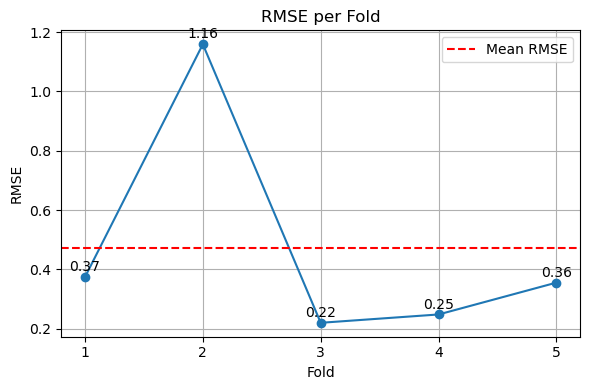

In [20]:
#Plotting the scores
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o')
plt.title('RMSE per Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(range(1, len(rmse_scores) + 1))
plt.tight_layout()

plt.axhline(y=sum(rmse_scores)/len(rmse_scores), color='red', linestyle='--', label='Mean RMSE')
plt.legend()

for i, v in enumerate(rmse_scores):
    plt.text(i + 1, v + 0.02, f"{v:.2f}", ha='center')
    
plt.show()

#plt.savefig("rmse_per_fold.png", dpi=300, bbox_inches='tight')

##### *Scaling*

In [21]:
# Scale numeric columns
X_train_glm = X_train_glm_original2.copy()
X_test_glm = X_test_glm_original2.copy()
y_train_glm = y_train_glm_original2.copy()
y_test_glm = y_test_glm_original2.copy()

scaler = StandardScaler()
X_train_glm[num_cols_reduced] = scaler.fit_transform(X_train_glm[num_cols_reduced])

# Align to training columns
X_test_glm = X_test_glm.reindex(columns=X_train_glm.columns, fill_value=0)

# Scale using final scaler
X_test_glm[num_cols_reduced] = scaler.transform(X_test_glm[num_cols_reduced])

#### Training, Prediction and Evaluation

In [22]:
# Train Final GLM Model
final_glm = PoissonRegressor(alpha=0.1, max_iter=300)
final_glm.fit(X_train_glm, y_train_glm)

PoissonRegressor(alpha=0.1, max_iter=300)

In [23]:
# Predict
y_train_glm_pred = final_glm.predict(X_train_glm)
y_test_glm_pred = final_glm.predict(X_test_glm)

y_test_glm_pred = np.clip(y_test_glm_pred, 0, 1e6)

In [24]:
# Evaluation function
def evaluate_model(y_true, y_pred, dataset_name):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) 
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} RMSE: {rmse:.4f}")
    print(f"{dataset_name} MAE:  {mae:.4f}")
    print(f"{dataset_name} MAPE:  {mape:.4f}")
    print(f"{dataset_name} R²:   {r2:.4f}\n")

In [25]:
# Evaluate
evaluate_model(y_train_glm, y_train_glm_pred, dataset_name="Train (GLM)")
evaluate_model(y_test_glm, y_test_glm_pred, dataset_name="Test (GLM)")

Train (GLM) RMSE: 0.1842
Train (GLM) MAE:  0.1426
Train (GLM) MAPE:  0.0356
Train (GLM) R²:   0.9345

Test (GLM) RMSE: 0.2018
Test (GLM) MAE:  0.1562
Test (GLM) MAPE:  0.0375
Test (GLM) R²:   0.9216



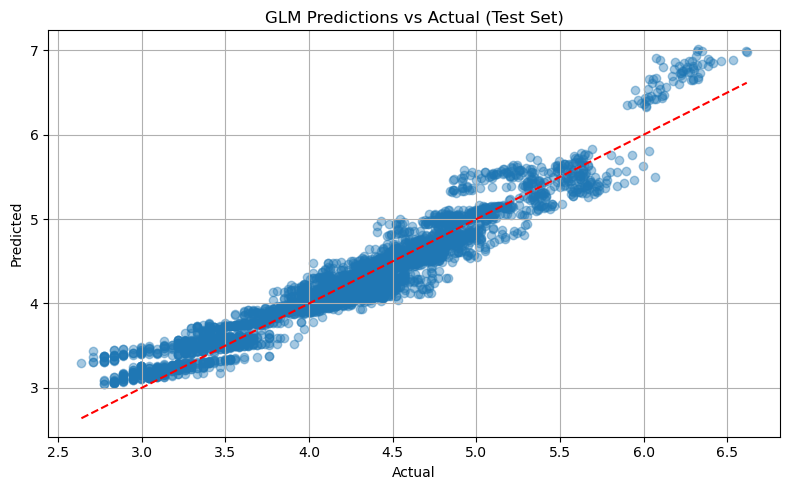

In [26]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_glm, y_test_glm_pred, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GLM Predictions vs Actual (Test Set)")
plt.grid(True)
plt.plot([y_test_glm.min(), y_test_glm.max()], [y_test_glm.min(), y_test_glm.max()], 'r--')
plt.tight_layout()
plt.show()

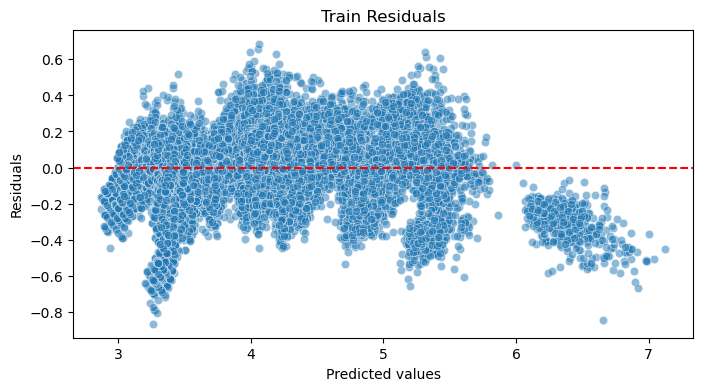

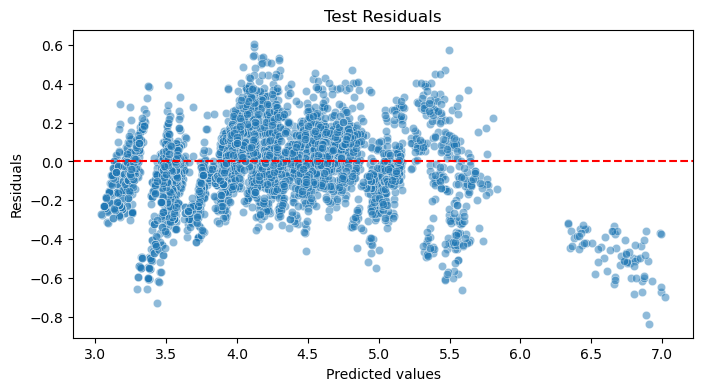

In [27]:
# Residual plot (train)
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_train_glm_pred, y=y_train_glm - y_train_glm_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Residual plot (test)
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test_glm_pred, y=y_test_glm - y_test_glm_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Test Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

### 3. ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA)

#### ARIMA 

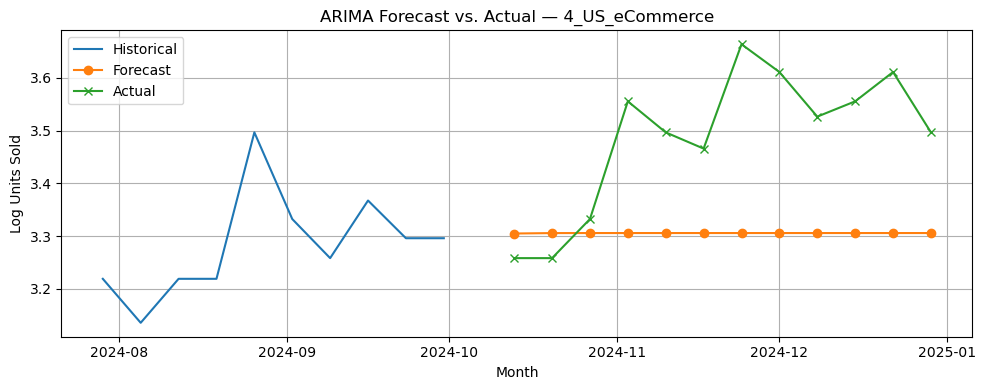

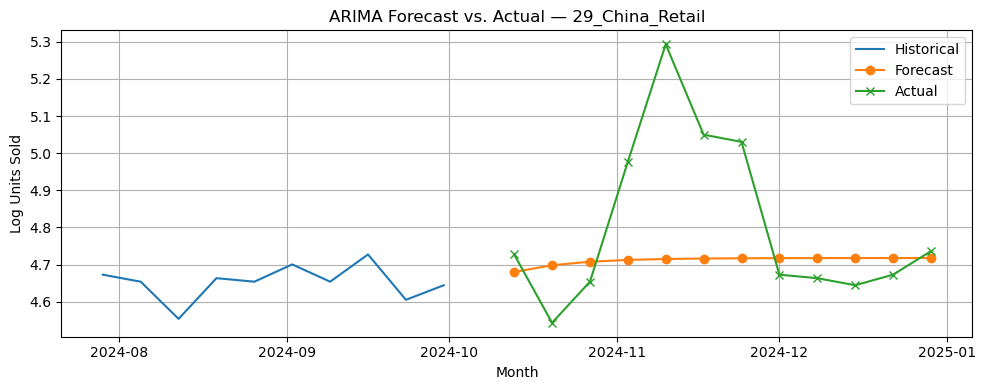

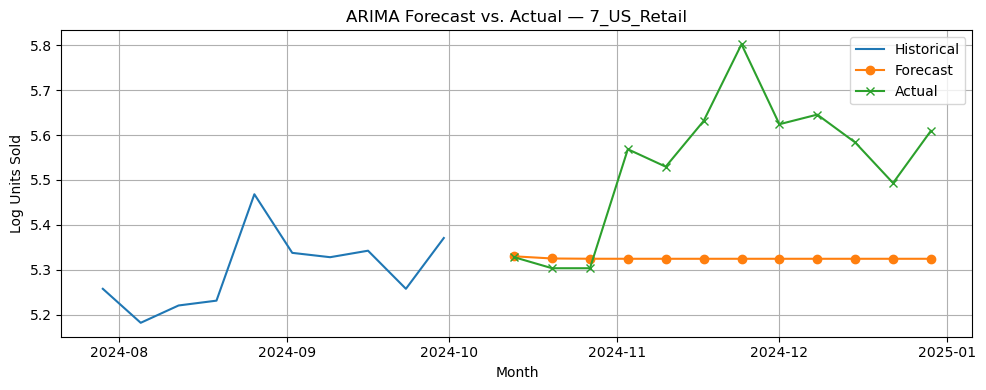

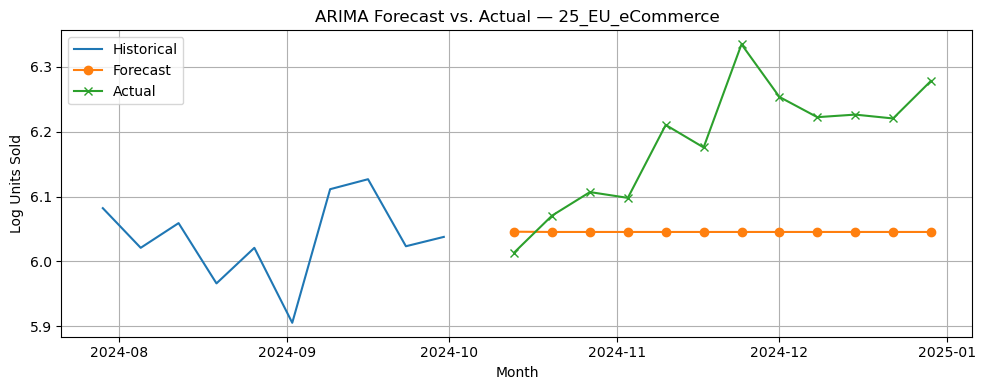

In [28]:
sku_ids = ['4_US_eCommerce', '29_China_Retail', '7_US_Retail', '25_EU_eCommerce']
results = []

# Loop through selected SKUs
for sku_id in sku_ids:
    try:
        # Step 1: Prepare training series
        series_df = train_featured_start[
            train_featured_start["Pseudo_SKU_ID"] == sku_id
        ].sort_values("Date")

        ts = series_df.set_index("Date")["Units_Sold_Log"]
        ts.index = ts.index.to_period("W-SUN")
        ts = ts.asfreq("W-SUN").dropna()

        # Step 2: Fit ARIMA model (1,1,1 as baseline)
        arima_model = ARIMA(ts, order=(1, 1, 1))
        arima_model_fit = arima_model.fit()

        # Step 3: Forecast
        forecast_periods = 12
        forecast = arima_model_fit.forecast(steps=forecast_periods)

        # Step 4: Get test actuals
        test_series = test_featured_start[
            test_featured_start["Pseudo_SKU_ID"] == sku_id
        ].sort_values("Date").set_index("Date")["Units_Sold_Log"].iloc[:forecast_periods]
        test_series.index = pd.to_datetime(test_series.index)

        # Step 5: Align forecast index to test period
        forecast_index = pd.date_range(start=ts.to_timestamp().index[-1] + pd.Timedelta(weeks=1),
                                       periods=forecast_periods, freq="W-SUN")
        forecast.index = forecast_index

        # Step 6: Evaluate (convert back to original scale)
        y_true = np.expm1(test_series)
        y_pred = np.expm1(forecast)

        mae = mean_absolute_error(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        results.append({
            'SKU_ID': sku_id,
            'RMSE': round(rmse, 2),
            'MAE': round(mae, 2),
            'MAPE': round(mape, 4),
            'R²': round(r2, 4)
        })

        # Step 7: Optional plot
        plt.figure(figsize=(10, 4))
        plt.plot(ts[-10:].to_timestamp(), label="Historical")
        plt.plot(forecast.index, forecast.values, label="Forecast", marker='o')
        plt.plot(test_series.index, test_series.values, label="Actual", marker='x')
        plt.title(f"ARIMA Forecast vs. Actual — {sku_id}")
        plt.grid(True)
        plt.legend()
        plt.xlabel("Month")
        plt.ylabel("Log Units Sold")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {sku_id}: {e}")

In [29]:
# Metrics table
arima_metrics_df = pd.DataFrame(results)

In [30]:
# Merge cluster info with metrics
arima_metrics_df = arima_metrics_df.merge(
    test_featured_start[['Pseudo_SKU_ID', 'Demand_Label']].drop_duplicates(),
    left_on='SKU_ID', right_on='Pseudo_SKU_ID',
    how='left'
)

# Showing metrics together with demand label
arima_metrics_df[['Pseudo_SKU_ID', 'Demand_Label', 'RMSE', 'MAE', 'MAPE', 'R²']].sort_values('Demand_Label')

Pseudo_SKU_ID                        Demand_Label   RMSE    MAE    MAPE  \
2      7_US_Retail              High Demand / Volatile  62.96  52.30  0.1887   
0   4_US_eCommerce                 Low Demand / Stable   6.98   6.07  0.1789   
1  29_China_Retail              Medium Demand / Stable  32.76  21.58  0.1456   
3  25_EU_eCommerce  Very High Demand / Highly Volatile  77.95  67.09  0.1318   

       R²  
2 -1.8855  
0 -1.9067  
1 -0.2041  
3 -2.2544

In [31]:
# Summary table or the SARIMA model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Units_Sold_Log   No. Observations:                   93
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  47.618
Date:                Wed, 28 May 2025   AIC                            -89.236
Time:                        13:20:16   BIC                            -81.671
Sample:                    01-01-2023   HQIC                           -86.183
                         - 10-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0515      0.127     -0.407      0.684      -0.300       0.197
ma.L1         -0.5921      0.125     -4.726      0.000      -0.838      -0.347
sigma2         0.0207      0.002     10.951      0.0

#### SARIMA

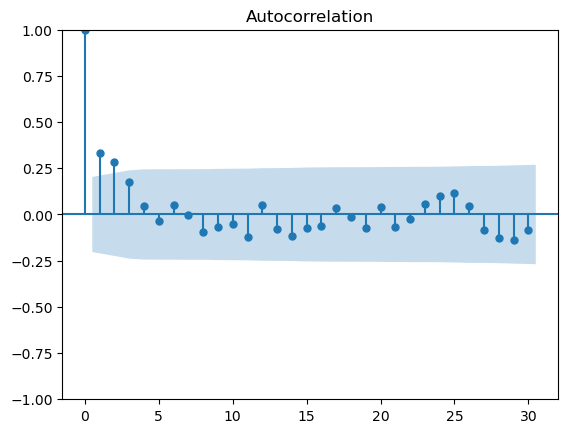

In [32]:
# Checking seasonality
plot_acf(ts, lags=30)
plt.show()

There is no strong repeated spikes at regular intervals, which would indicate clear seasonality.  
(An autocorrelation plot shows how strongly the current value of a time series is related to its past values (lags). If the plot shows repeating spikes at regular intervals, it suggests the presence of seasonality — a consistent pattern that repeats over time.)

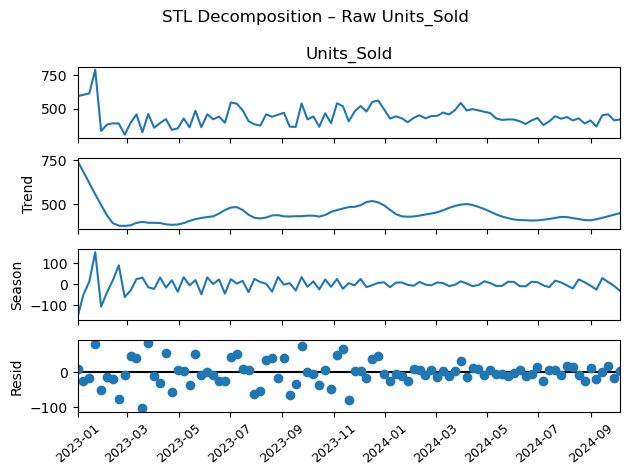

In [33]:
# Checking decomposition - original target column

ts_raw = series_df.set_index("Date")["Units_Sold"]

if isinstance(ts_raw.index, pd.PeriodIndex):
    ts_raw.index = ts_raw.index.to_timestamp()
ts_raw = ts_raw.sort_index().asfreq("W-SUN")

# STL on raw
stl_raw = STL(ts_raw, period=4)  # or 6, 12 depending on observed frequency
res_raw = stl_raw.fit()
res_raw.plot()
plt.suptitle("STL Decomposition – Raw Units_Sold")
plt.xticks(fontsize=9, rotation=40)  
plt.tight_layout()
plt.show()

C:\Users\veszt\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


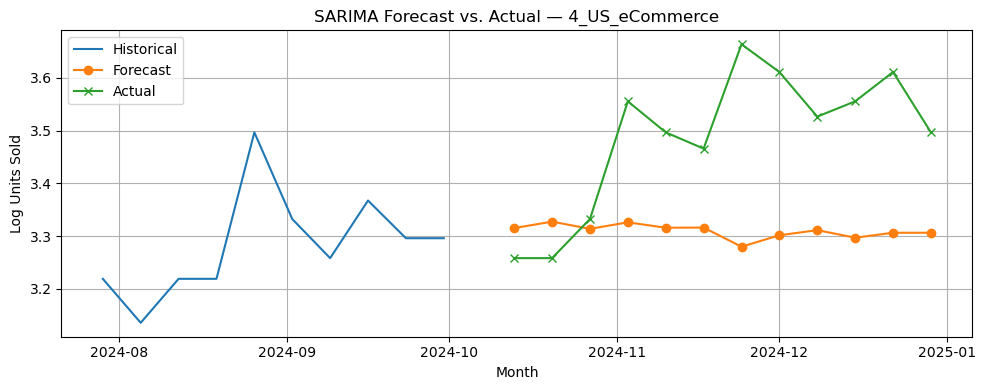

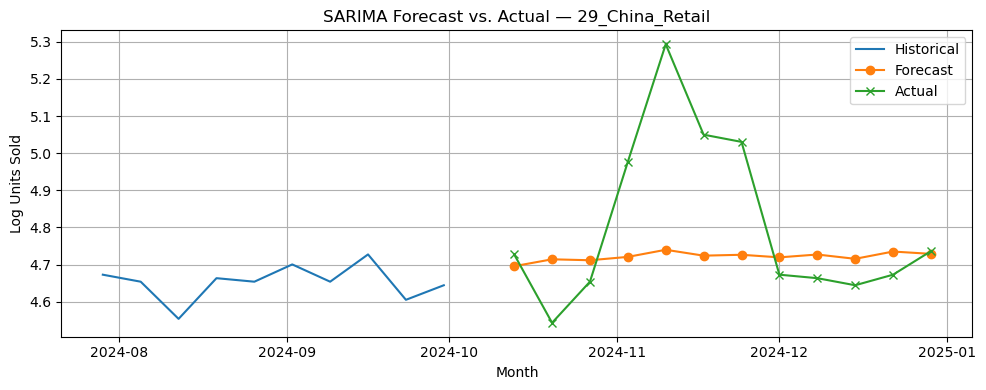

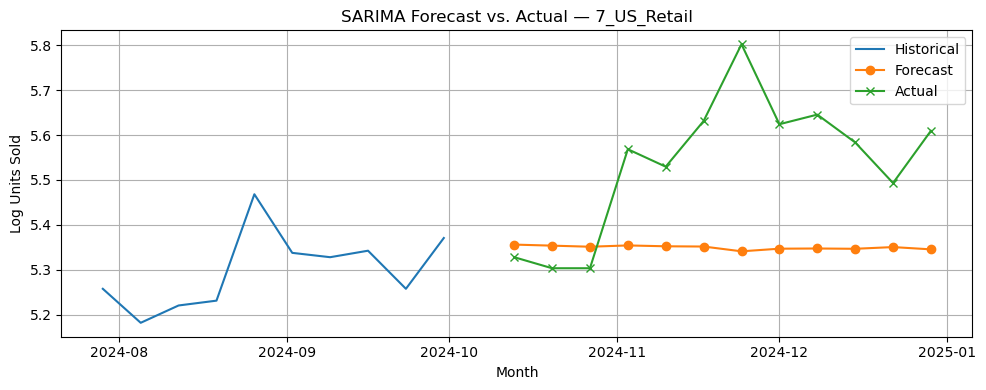

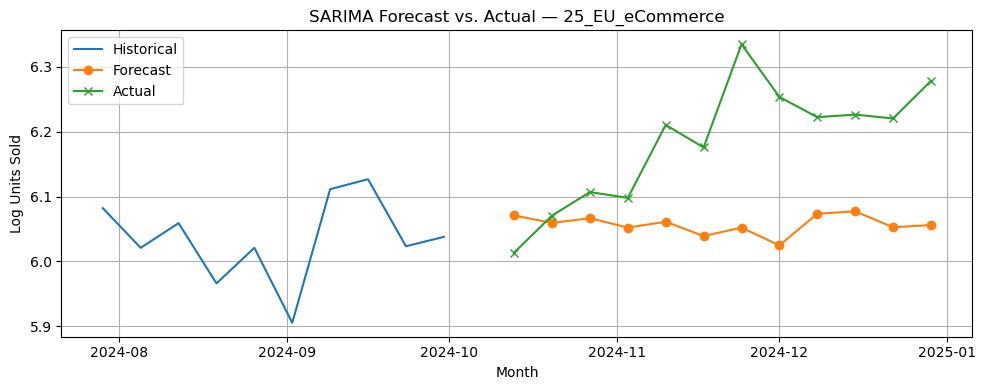

In [34]:
sku_ids = ['4_US_eCommerce', '29_China_Retail', '7_US_Retail', '25_EU_eCommerce']
results = []

# Loop through selected SKUs
for sku_id in sku_ids:
    try:
        # Step 1: Prepare training series
        series_df = train_featured_start[
            train_featured_start["Pseudo_SKU_ID"] == sku_id
        ].sort_values("Date")

        ts = series_df.set_index("Date")["Units_Sold_Log"]
        ts.index = ts.index.to_period("W-SUN")
        ts = ts.asfreq("W-SUN").dropna()

        # Step 2: Fit ARIMA model (1,1,1 as baseline)
        sarima_model = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
        sarima_model_fit = sarima_model.fit()

        # Step 3: Forecast
        forecast_periods = 12
        forecast = sarima_model_fit.forecast(steps=forecast_periods)

        # Step 4: Get test actuals
        test_series = test_featured_start[
            test_featured_start["Pseudo_SKU_ID"] == sku_id
        ].sort_values("Date").set_index("Date")["Units_Sold_Log"].iloc[:forecast_periods]
        test_series.index = pd.to_datetime(test_series.index)

        # Step 5: Align forecast index to test period
        forecast_index = pd.date_range(start=ts.to_timestamp().index[-1] + pd.Timedelta(weeks=1),
                                       periods=forecast_periods, freq="W-SUN")
        forecast.index = forecast_index

        # Step 6: Evaluate (convert back to original scale)
        y_true = np.expm1(test_series)
        y_pred = np.expm1(forecast)

        mae = mean_absolute_error(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        results.append({
            'SKU_ID': sku_id,
            'RMSE': round(rmse, 2),
            'MAE': round(mae, 2),
            'MAPE': round(mape, 4),
            'R²': round(r2, 4)
        })

        # Step 7: Optional plot
        plt.figure(figsize=(10, 4))
        plt.plot(ts[-10:].to_timestamp(), label="Historical")
        plt.plot(forecast.index, forecast.values, label="Forecast", marker='o')
        plt.plot(test_series.index, test_series.values, label="Actual", marker='x')
        plt.title(f"SARIMA Forecast vs. Actual — {sku_id}")
        plt.grid(True)
        plt.legend()
        plt.xlabel("Month")
        plt.ylabel("Log Units Sold")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {sku_id}: {e}")

A little better capture of the actual trends - but still far from acceptable.

In [35]:
# Metrics table
sarima_metrics_df = pd.DataFrame(results)

# Merge cluster info with metrics
sarima_metrics_df =sarima_metrics_df.merge(
    test_featured_start[['Pseudo_SKU_ID', 'Demand_Label']].drop_duplicates(),
    left_on='SKU_ID', right_on='Pseudo_SKU_ID',
    how='left'
)

# Showing metrics together with demand label
sarima_metrics_df[['Pseudo_SKU_ID', 'Demand_Label', 'RMSE', 'MAE', 'MAPE', 'R²']].sort_values('Demand_Label')

Pseudo_SKU_ID                        Demand_Label   RMSE    MAE    MAPE  \
2      7_US_Retail              High Demand / Volatile  59.22  49.98  0.1818   
0   4_US_eCommerce                 Low Demand / Stable   7.03   6.10  0.1803   
1  29_China_Retail              Medium Demand / Stable  31.96  21.30  0.1450   
3  25_EU_eCommerce  Very High Demand / Highly Volatile  75.07  63.87  0.1255   

       R²  
2 -1.5528  
0 -1.9499  
1 -0.1458  
3 -2.0184

In [36]:
# Summary table or the SARIMA model
print(sarima_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      Units_Sold_Log   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                  49.220
Date:                             Wed, 28 May 2025   AIC                            -90.441
Time:                                     13:20:20   BIC                            -80.353
Sample:                                 01-01-2023   HQIC                           -86.369
                                      - 10-06-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0961      0.150     -0.642      0.521      -0.390       0.197
ma.L1         -0.5208      

#### SUMMARY
Models tested to forecast demand for the last 12 weeks of the second year: 

| Model         | What It Tried                    | AIC Score      | Did It Predict the Spikes? |
|---------------|----------------------------------|----------------|----------------------------|
| ARIMA         | Last week + last forecast error  | -89.236        | No — predicted flat        |
| SARIMA        | Added seasonal clues (like time of year) |-90.441 | No — missed it too         |

The spike likely came from an exogenous factor. Even with low AIC, a model can fail to capture real-world events it can't "see.

## <span style="color:blue">II. TRADITIONAL MACHINE LEARNING MODELS</span>

### 1. Regularized Linear Models

#### Ridge (Regularized Linear Regression with L2 Penalty)

In [37]:
X_train_ridge = X_train_glm.copy()
y_train_ridge = y_train_glm.copy()
X_test_ridge = X_test_glm.copy()
y_test_ridge = y_test_glm.copy()

In [38]:
# Define CV strategy
tscv = TimeSeriesSplit(n_splits=5)

# Define a range of alpha (regularization strength) values
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

# Create Ridge model with built-in cross-validation
ridge_model = RidgeCV(alphas=alphas, cv=tscv)
ridge_model.fit(X_train_ridge, y_train_ridge)

RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0],
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None))

In [39]:
print(f"Best alpha: {ridge_model.alpha_}")

Best alpha: 100.0


In [40]:
# Ensure test features match
X_test_ridge = X_test_ridge[X_train_ridge.columns]

# Predict
y_train_ridge_pred = ridge_model.predict(X_train_ridge)
y_test_ridge_pred = ridge_model.predict(X_test_ridge)

In [41]:
# Evaluation
evaluate_model(y_train_ridge, y_train_ridge_pred, "Train (Ridge)")
evaluate_model(y_test_ridge, y_test_ridge_pred, "Test (Ridge)")

Train (Ridge) RMSE: 0.1516
Train (Ridge) MAE:  0.1168
Train (Ridge) MAPE:  0.0289
Train (Ridge) R²:   0.9556

Test (Ridge) RMSE: 0.1732
Test (Ridge) MAE:  0.1347
Test (Ridge) MAPE:  0.0325
Test (Ridge) R²:   0.9422



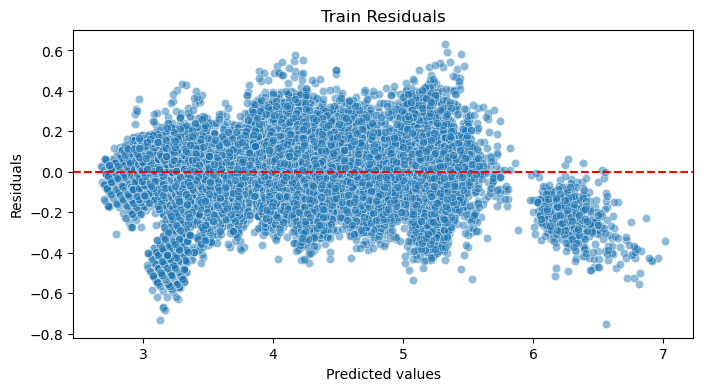

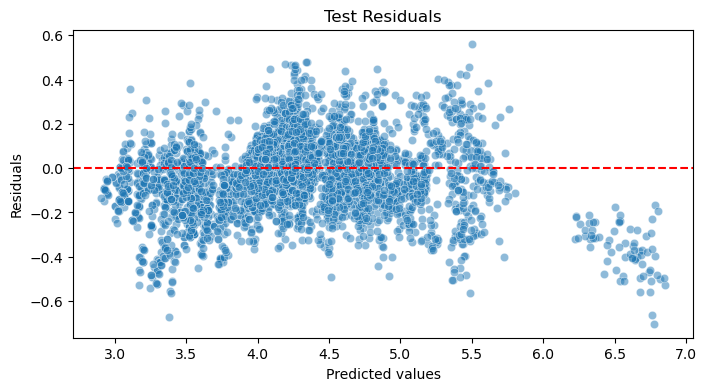

In [42]:
# Residual plot (train)
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_train_ridge_pred, y=y_train_ridge - y_train_ridge_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Residual plot (test)
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test_ridge_pred, y=y_test_ridge - y_test_ridge_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Test Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

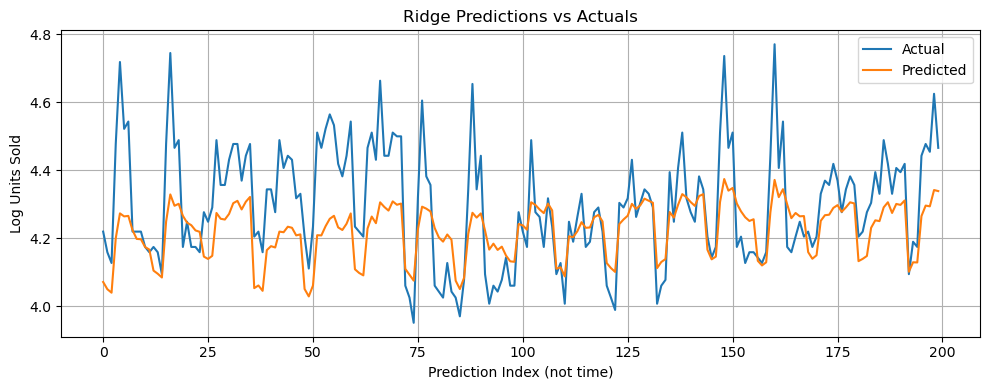

In [43]:
#Predictions vs actual
plt.figure(figsize=(10, 4))
plt.plot(y_test_ridge.values[:200], label="Actual")
plt.plot(y_test_ridge_pred[:200], label="Predicted")
plt.title("Ridge Predictions vs Actuals")
plt.xlabel("Prediction Index (not time)")
plt.ylabel("Log Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Lasso (Regularized Linear Regression with L1 Penalty)

In [44]:
X_train_lasso = X_train_glm.copy()
y_train_lasso = y_train_glm.copy()
X_test_lasso = X_test_glm.copy()
y_test_lasso = y_test_glm.copy()

In [45]:
# Time-aware CV
tscv = TimeSeriesSplit(n_splits=5)

# Define a range of alpha values
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

# LassoCV chooses the best alpha
lasso_model = LassoCV(alphas=alphas, cv=tscv, max_iter=10000)
lasso_model.fit(X_train_lasso, y_train_lasso)
print(f"Best alpha (Lasso): {lasso_model.alpha_}")

Best alpha (Lasso): 0.01


In [46]:
y_train_lasso_pred = lasso_model.predict(X_train_lasso)
y_test_lasso_pred = lasso_model.predict(X_test_lasso)

evaluate_model(y_train_lasso, y_train_lasso_pred, "Train (Lasso)")
evaluate_model(y_test_lasso, y_test_lasso_pred, "Test (Lasso)")

Train (Lasso) RMSE: 0.1899
Train (Lasso) MAE:  0.1502
Train (Lasso) MAPE:  0.0378
Train (Lasso) R²:   0.9303

Test (Lasso) RMSE: 0.2052
Test (Lasso) MAE:  0.1642
Test (Lasso) MAPE:  0.0394
Test (Lasso) R²:   0.9188



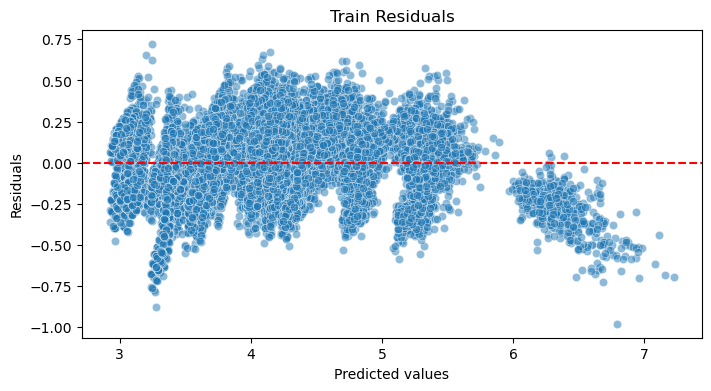

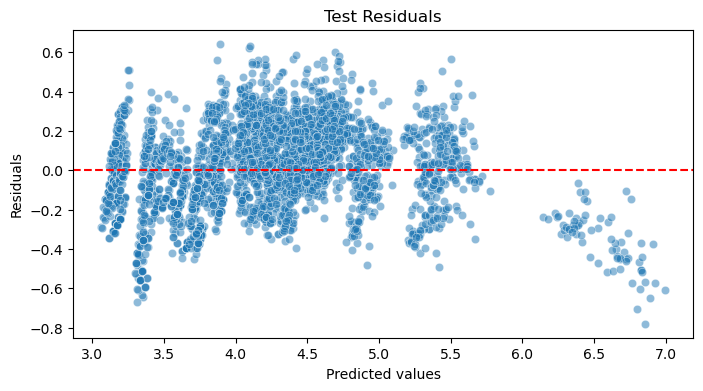

In [47]:
# Residual plot (train)
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_train_lasso_pred, y=y_train_lasso - y_train_lasso_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Residual plot (test)
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test_lasso_pred, y=y_test_lasso - y_test_lasso_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Test Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

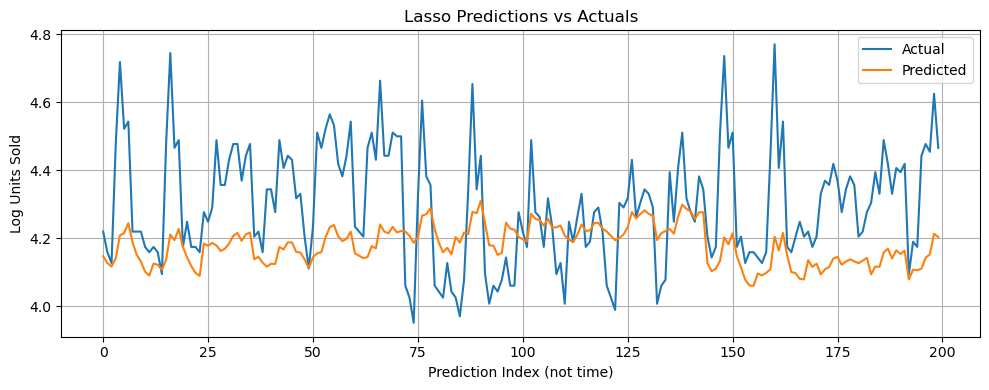

In [48]:
#Predictions vs actual
plt.figure(figsize=(10, 4))
plt.plot(y_test_lasso.values[:200], label="Actual")
plt.plot(y_test_lasso_pred[:200], label="Predicted")
plt.title("Lasso Predictions vs Actuals")
plt.xlabel("Prediction Index (not time)")
plt.ylabel("Log Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### ElasticNet (Regularized Linear Regression with Combined L1 and L2 Penalties)

In [49]:
X_train_elastic = X_train_glm.copy()
y_train_elastic = y_train_glm.copy()
X_test_elastic = X_test_glm.copy()
y_test_elastic = y_test_glm.copy()

In [50]:
# Time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# ElasticNetCV automatically tunes alpha (regularization strength) and l1_ratio
elastic_model = ElasticNetCV(
    alphas=[0.01, 0.1, 1.0, 10.0],
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0],  # 1.0 = Lasso, 0 = Ridge
    cv=tscv,
    max_iter=10000
)

# Fit the model
elastic_model.fit(X_train_elastic, y_train_elastic)

ElasticNetCV(alphas=[0.01, 0.1, 1.0, 10.0],
             cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0], max_iter=10000)

In [51]:
print(f"Best alpha: {elastic_model.alpha_}")
print(f"Best l1_ratio: {elastic_model.l1_ratio_}")

Best alpha: 0.1
Best l1_ratio: 0.1


In [52]:
X_test_elastic = X_test_elastic[X_train_elastic.columns]

y_train_elastic_pred = elastic_model.predict(X_train_elastic)
y_test_elastic_pred = elastic_model.predict(X_test_elastic)

evaluate_model(y_train_elastic, y_train_elastic_pred, "Train (Elastic)")
evaluate_model(y_test_elastic, y_test_elastic_pred, "Test (Elastic)")

Train (Elastic) RMSE: 0.2005
Train (Elastic) MAE:  0.1585
Train (Elastic) MAPE:  0.0405
Train (Elastic) R²:   0.9224

Test (Elastic) RMSE: 0.2150
Test (Elastic) MAE:  0.1720
Test (Elastic) MAPE:  0.0420
Test (Elastic) R²:   0.9109



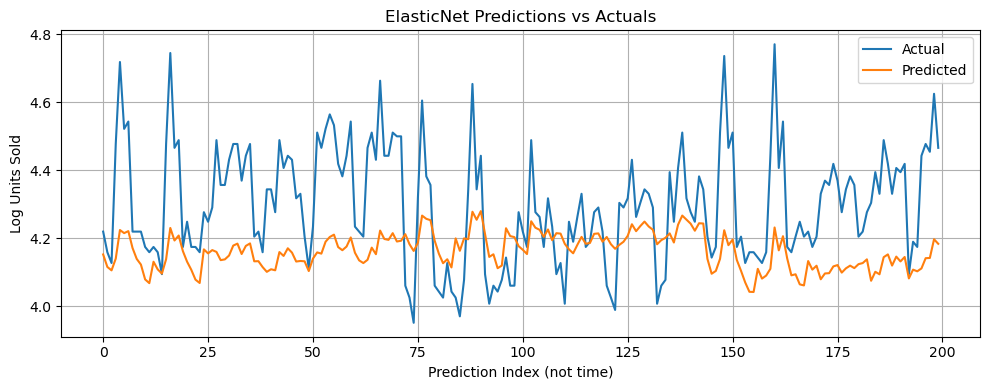

In [53]:
#Predictions vs actual
plt.figure(figsize=(10, 4))
plt.plot(y_test_elastic.values[:200], label="Actual")
plt.plot(y_test_elastic_pred[:200], label="Predicted")
plt.title("ElasticNet Predictions vs Actuals")
plt.xlabel("Prediction Index (not time)")
plt.ylabel("Log Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### SUMMARY                    
<div style="text-align: center">Regularized Linear Model Performance Comparison (Best Highlighted)</p>
                                             

| Model       | Train RMSE | Test RMSE | Test MAE | Test MAPE | Test R² | 
|-------------|------------|-----------|----------|-----------|---------| 
| **Ridge**   | **0.1516** | **0.1732** | **0.1347**| **0.0325** | **0.9422**| 
| Lasso       | 0.1899     | 0.2052    | 0.1642   | 0.0394    | 0.9188  | 
| ElasticNet  | 0.2005     | 0.2150    | 0.1720   | 0.0420    | 0.9109  |  
 

<div style="text-align: center">The Ridge model provided the best test performance (lowest RMSE/MAE/MAPE, highest R²).</p> 

### 3. Tree Model - LightGBM

#### "Simple" LightGBM

In [54]:
# Create X and y
id_cols = ['Pseudo_SKU_ID', 'Product_ID']
target_col = "Units_Sold_Log"
drop_cols = ['Units_Sold', 'Demand_Label', 'Date']

X_train_lgb = train_encoded.copy().drop(columns=id_cols + [target_col] + drop_cols)
y_train_lgb = train_encoded.copy()[target_col]

X_test_lgb = test_encoded.copy().drop(columns=id_cols + [target_col] + drop_cols)
y_test_lgb = test_encoded.copy()[target_col]

In [55]:
# Transforming cat_cols
cat_cols = ['Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage',
    'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']

for col in cat_cols:
    if col in X_train_lgb.columns:
        X_train_lgb[col] = X_train_lgb[col].astype("category")
    if col in X_test_lgb.columns:
        X_test_lgb[col] = X_test_lgb[col].astype("category")

In [56]:
# TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
cv_rmse = []

# Run TimeSeriesSplit CV
for train_idx, val_idx in tscv.split(X_train_lgb):
    X_tr, X_val = X_train_lgb.iloc[train_idx], X_train_lgb.iloc[val_idx]
    y_tr, y_val = y_train_lgb.iloc[train_idx], y_train_lgb.iloc[val_idx]

    model_cv = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        verbose=-1
    )

    model_cv.fit(X_tr, y_tr)
    preds = model_cv.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    cv_rmse.append(rmse)

print(f"Average CV RMSE (TimeSeriesSplit): {np.mean(cv_rmse):.4f}")

Average CV RMSE (TimeSeriesSplit): 0.2492


In [57]:
# Final training on full training set
lgb_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train_lgb, y_train_lgb)

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=500,
              random_state=42, verbose=-1)

In [58]:
# Predict
y_pred_train_lgb = lgb_model.predict(X_train_lgb)
y_pred_test_lgb = lgb_model.predict(X_test_lgb)

In [59]:
#Evaluating performance
evaluate_model(y_train_lgb, y_pred_train_lgb, "Train (lgb)")
evaluate_model(y_test_lgb, y_pred_test_lgb, "Test (lgb)")

Train (lgb) RMSE: 0.0261
Train (lgb) MAE:  0.0199
Train (lgb) MAPE:  0.0049
Train (lgb) R²:   0.9987

Test (lgb) RMSE: 0.0765
Test (lgb) MAE:  0.0623
Test (lgb) MAPE:  0.0152
Test (lgb) R²:   0.9887



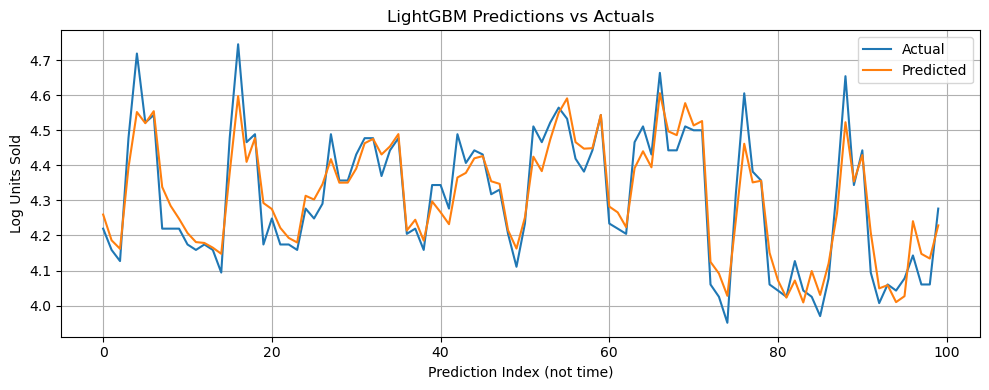

In [60]:
#Predictions vs actual

plt.figure(figsize=(10, 4))
plt.plot(y_test_lgb.values[:100], label="Actual")
plt.plot(y_pred_test_lgb[:100], label="Predicted")
plt.title("LightGBM Predictions vs Actuals")
plt.xlabel("Prediction Index (not time)")
plt.ylabel("Log Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Note:**  
Train R²: 0.998/ - The model has nearly memorized the training set. It’s basically too perfect.   

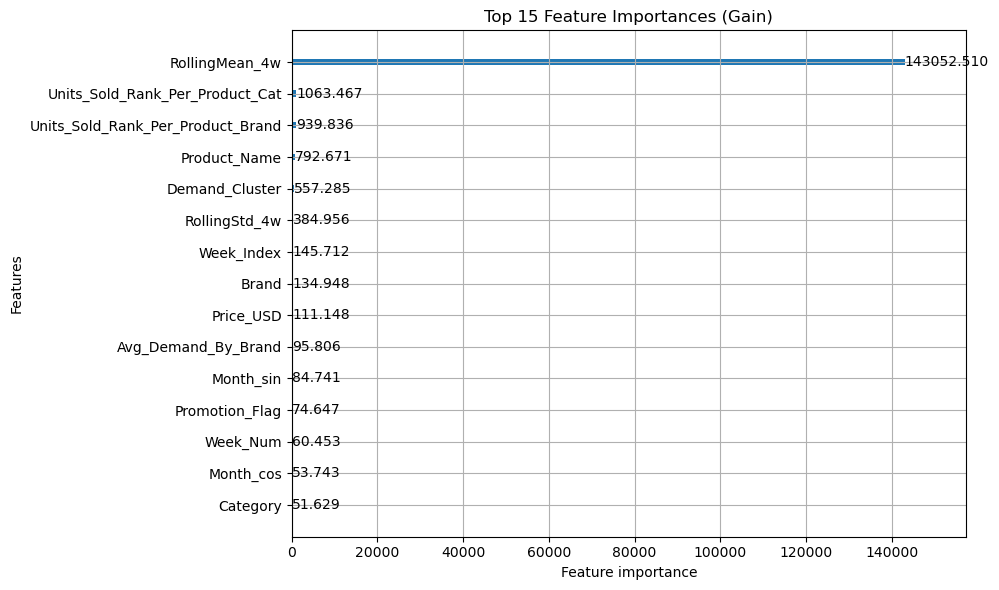

In [61]:
#Feature importance check

lgb.plot_importance(lgb_model.booster_, max_num_features=15, importance_type="gain", figsize=(10, 6))
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

#### Regularized LightGBM

In [62]:
# Create X and y
id_cols = ['Pseudo_SKU_ID', 'Product_ID']
target_col = "Units_Sold_Log"
drop_cols = ['Units_Sold', 'Demand_Label', 'Date']
X_train_lgb_reg = train_encoded.copy().drop(columns=id_cols + [target_col] + drop_cols)
y_train_lgb_reg = train_encoded.copy()[target_col]

X_test_lgb_reg = test_encoded.copy().drop(columns=id_cols + [target_col] + drop_cols)
y_test_lgb_reg = test_encoded.copy()[target_col]

In [63]:
# Transforming cat_cols
cat_cols = ['Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage',
    'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']
for col in cat_cols:
    if col in X_train_lgb_reg.columns:
        X_train_lgb_reg[col] = X_train_lgb_reg[col].astype("category")
    if col in X_test_lgb_reg.columns:
        X_test_lgb_reg[col] = X_test_lgb_reg[col].astype("category")

In [64]:
lgb_model_reg = LGBMRegressor(
    n_estimators=200,
    num_leaves=31,
    learning_rate=0.05,
    max_depth=3,
    min_child_samples=20,
    reg_alpha=10.0,
    reg_lambda=1.0,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1
)

In [65]:
#Adding early stopping
lgb_model_reg.fit(
    X_train_lgb_reg, y_train_lgb_reg,
    eval_set=[(X_test_lgb_reg, y_test_lgb_reg)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),   
        log_evaluation(period=10)             
    ]
)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 0.460883	valid_0's l2: 0.212413
[20]	valid_0's rmse: 0.30492	valid_0's l2: 0.092976
[30]	valid_0's rmse: 0.212082	valid_0's l2: 0.0449789
[40]	valid_0's rmse: 0.160209	valid_0's l2: 0.0256669
[50]	valid_0's rmse: 0.134285	valid_0's l2: 0.0180324
[60]	valid_0's rmse: 0.120434	valid_0's l2: 0.0145045
[70]	valid_0's rmse: 0.113627	valid_0's l2: 0.012911
[80]	valid_0's rmse: 0.108781	valid_0's l2: 0.0118332
[90]	valid_0's rmse: 0.105508	valid_0's l2: 0.011132
[100]	valid_0's rmse: 0.103517	valid_0's l2: 0.0107158
[110]	valid_0's rmse: 0.101412	valid_0's l2: 0.0102844
[120]	valid_0's rmse: 0.100785	valid_0's l2: 0.0101577
[130]	valid_0's rmse: 0.0993805	valid_0's l2: 0.00987647
[140]	valid_0's rmse: 0.0988409	valid_0's l2: 0.00976953
[150]	valid_0's rmse: 0.0979595	valid_0's l2: 0.00959606
[160]	valid_0's rmse: 0.0969604	valid_0's l2: 0.00940131
[170]	valid_0's rmse: 0.0963278	valid_0's l2: 0.00927905
[180]	va

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=3,
              n_estimators=200, random_state=42, reg_alpha=10.0, reg_lambda=1.0,
              verbose=-1)

In [66]:
#Prediction
y_pred_train_lgb_reg = lgb_model_reg.predict(X_train_lgb_reg)
y_pred_test_lgb_reg = lgb_model_reg.predict(X_test_lgb_reg)

In [67]:
#Evaluating performance
evaluate_model(y_train_lgb_reg, y_pred_train_lgb_reg, "Train (lgb_reg)")
evaluate_model(y_test_lgb_reg, y_pred_test_lgb_reg, "Test (lgb_reg)")

Train (lgb_reg) RMSE: 0.0642
Train (lgb_reg) MAE:  0.0479
Train (lgb_reg) MAPE:  0.0120
Train (lgb_reg) R²:   0.9920

Test (lgb_reg) RMSE: 0.0948
Test (lgb_reg) MAE:  0.0738
Test (lgb_reg) MAPE:  0.0177
Test (lgb_reg) R²:   0.9827



In [68]:
print("Best iteration:", lgb_model_reg.best_iteration_)

Best iteration: 200


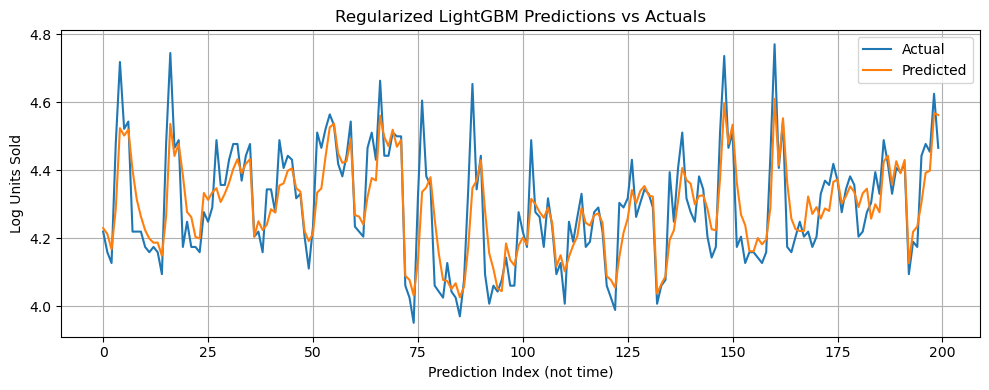

In [69]:
#Predictions vs actual

plt.figure(figsize=(10, 4))
plt.plot(y_test_lgb_reg.values[:200], label="Actual")
plt.plot(y_pred_test_lgb_reg[:200], label="Predicted")
plt.title("Regularized LightGBM Predictions vs Actuals")
plt.xlabel("Prediction Index (not time)")
plt.ylabel("Log Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### *Feature Importance for Explainability*

##### Simple Feature importance

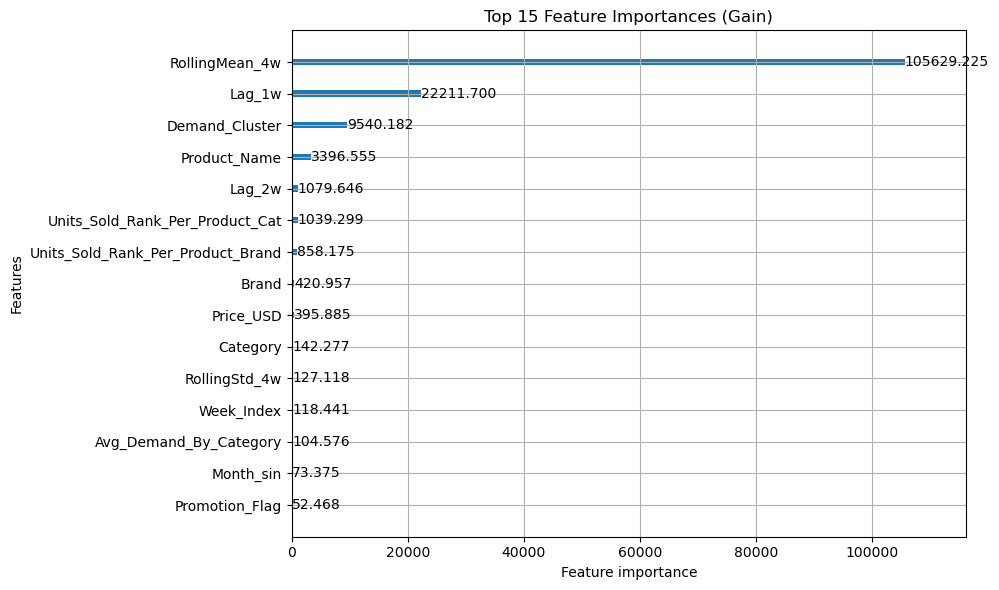

In [70]:
#Feature importance check

lgb.plot_importance(lgb_model_reg.booster_, max_num_features=15, importance_type="gain", figsize=(10, 6))
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

##### SHAP and Waterfall

In [71]:
#Feature contribution to the prediction

# Building SHAP explainer from trained LightGBM model
explainer = shap.Explainer(lgb_model_reg)

# Computing SHAP values for the test set
shap_values = explainer(X_test_lgb_reg)

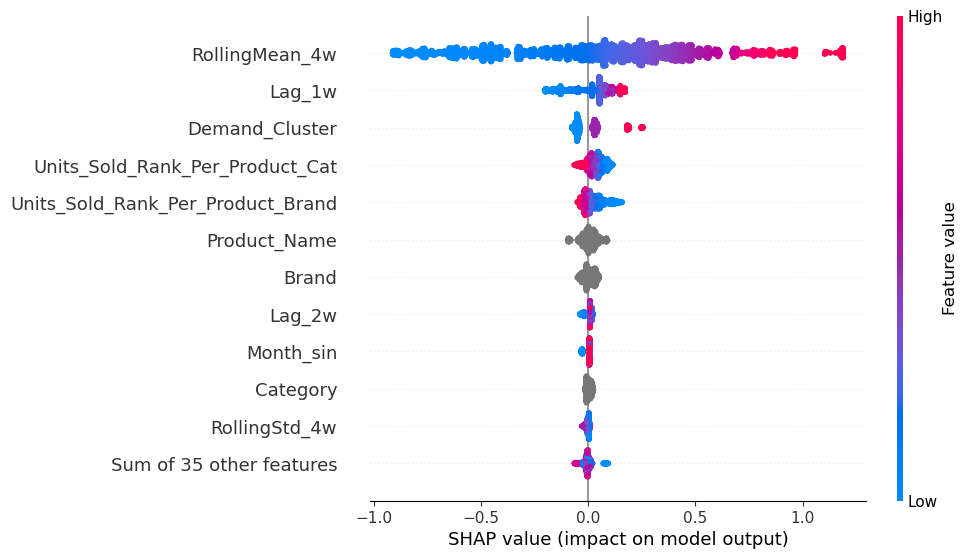

In [72]:
#Global Summary Plot (Top Features)
shap.plots.beeswarm(shap_values, max_display=12)

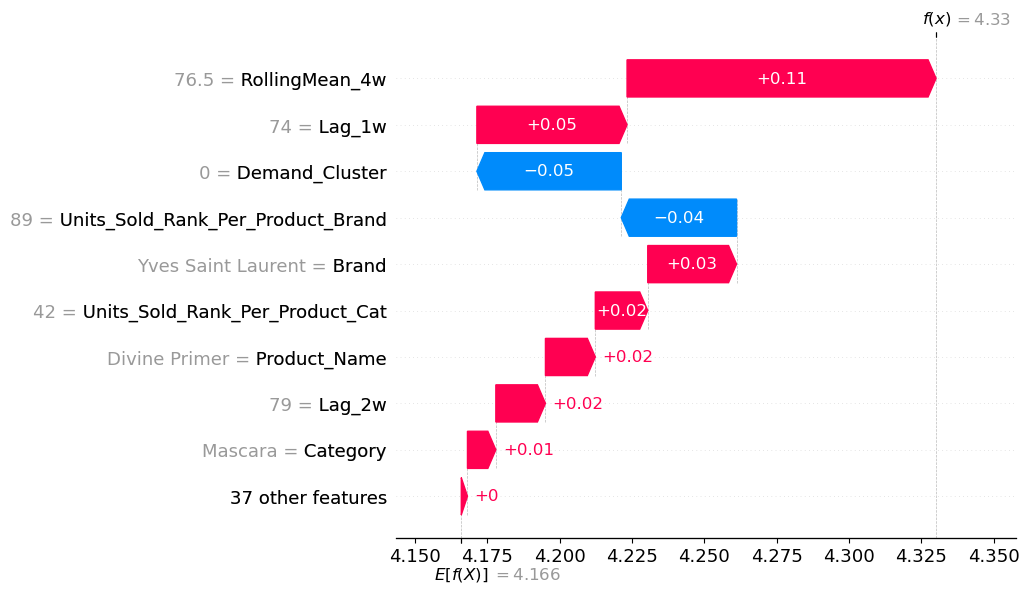

In [73]:
# Explaining the first test prediction
shap.plots.waterfall(shap_values[251])

**Note:** RollingMean_4w is the most impactful feature, where higher last-week sales (in red) increase demand forecasts, while lower values (in blue) pull predictions down — showing the model strongly relies on recent demand trends.  

#### Light GBM with Random Search

In [74]:
# Create X and y
id_cols = ['Pseudo_SKU_ID', 'Product_ID']
target_col = "Units_Sold_Log"
drop_cols = ['Units_Sold', 'Demand_Label', 'Date']
X_train_lgb_rand = train_encoded.copy().drop(columns=id_cols + [target_col] + drop_cols)
y_train_lgb_rand = train_encoded.copy()[target_col]

X_test_lgb_rand = test_encoded.copy().drop(columns=id_cols + [target_col] + drop_cols)
y_test_lgb_rand = test_encoded.copy()[target_col]

In [75]:
# Transforming cat_cols
cat_cols = ['Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage',
    'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']
for col in cat_cols:
    if col in X_train_lgb_rand.columns:
        X_train_lgb_rand[col] = X_train_lgb_rand[col].astype("category")
    if col in X_test_lgb_rand.columns:
        X_test_lgb_rand[col] = X_test_lgb_rand[col].astype("category")

In [76]:
# #Using RandomSearch

param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 300, 500],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0]
}

In [77]:
#Setup

lgb_model_rand = LGBMRegressor(random_state=42, verbose=-1)

random_search = RandomizedSearchCV(
    estimator=lgb_model_rand,
    param_distributions=param_grid,
    n_iter=30,                # Number of combinations to try
    scoring='neg_root_mean_squared_error',
    cv=4,
    random_state=42,
    verbose=0,
    n_jobs=1
)

In [78]:
# Run

random_search.fit(X_train_lgb_rand, y_train_lgb_rand)

RandomizedSearchCV(cv=4, estimator=LGBMRegressor(random_state=42, verbose=-1),
                   n_iter=30, n_jobs=1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [50, 100, 300, 500],
                                        'num_leaves': [15, 31, 63],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [79]:
#Best Model
print("Best Parameters:", random_search.best_params_)

best_lgb_model_rand = random_search.best_estimator_

Best Parameters: {'subsample': 0.6, 'num_leaves': 63, 'n_estimators': 50, 'min_child_samples': 30, 'max_depth': 7, 'learning_rate': 0.1}


In [80]:
#Preciction
y_pred_train_rand_best = best_lgb_model_rand.predict(X_train_lgb_rand)
y_pred_test_rand_best = best_lgb_model_rand.predict(X_test_lgb_rand)

In [81]:
#Evaluation
evaluate_model(y_train_lgb_rand, y_pred_train_rand_best, "Train (lgb_rand)")
evaluate_model(y_test_lgb_rand, y_pred_test_rand_best, "Test (lgb_rand)")

Train (lgb_rand) RMSE: 0.0437
Train (lgb_rand) MAE:  0.0328
Train (lgb_rand) MAPE:  0.0082
Train (lgb_rand) R²:   0.9963

Test (lgb_rand) RMSE: 0.0794
Test (lgb_rand) MAE:  0.0627
Test (lgb_rand) MAPE:  0.0152
Test (lgb_rand) R²:   0.9879



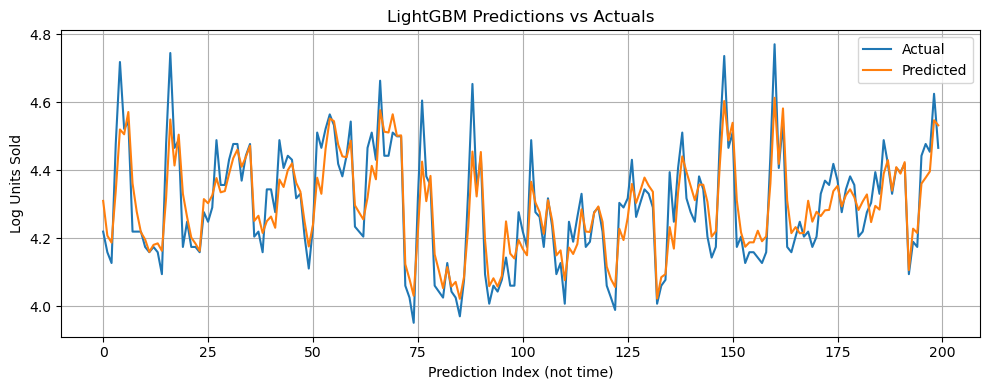

In [82]:
#Predictions vs actual

plt.figure(figsize=(10, 4))
plt.plot(y_test_lgb_rand.values[:200], label="Actual")
plt.plot(y_pred_test_rand_best[:200], label="Predicted")
plt.title("LightGBM Predictions vs Actuals")
plt.xlabel("Prediction Index (not time)")
plt.ylabel("Log Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### *Feature Importance*

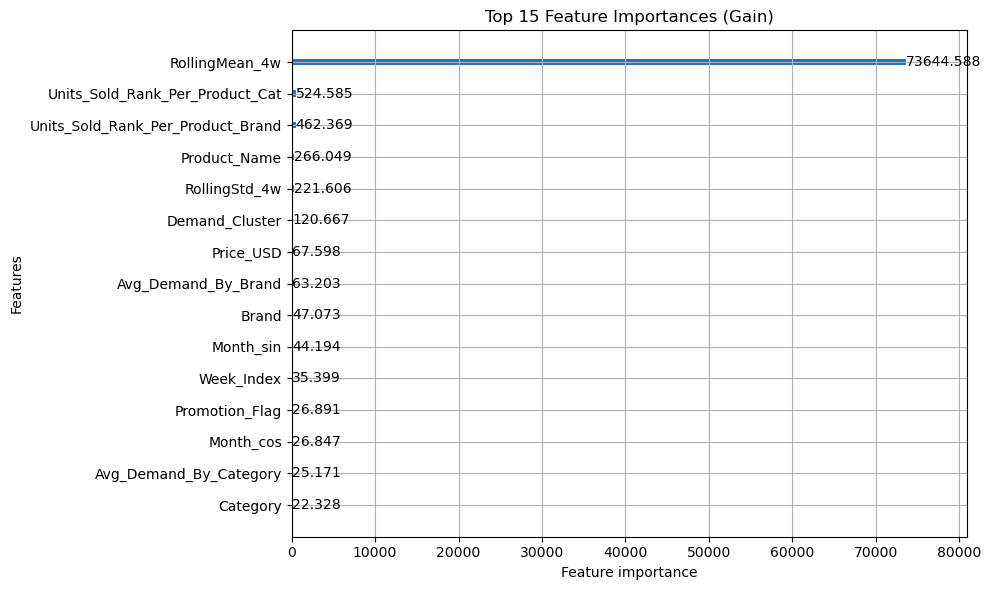

In [83]:
#Feature importance check

lgb.plot_importance(best_lgb_model_rand.booster_, max_num_features=15, importance_type="gain", figsize=(10, 6))
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

In [84]:
#Feature contribution to the prediction

# Building SHAP explainer from trained LightGBM model
explainer = shap.Explainer(best_lgb_model_rand)

# Computing SHAP values for the test set
shap_values = explainer(X_test_lgb_rand)

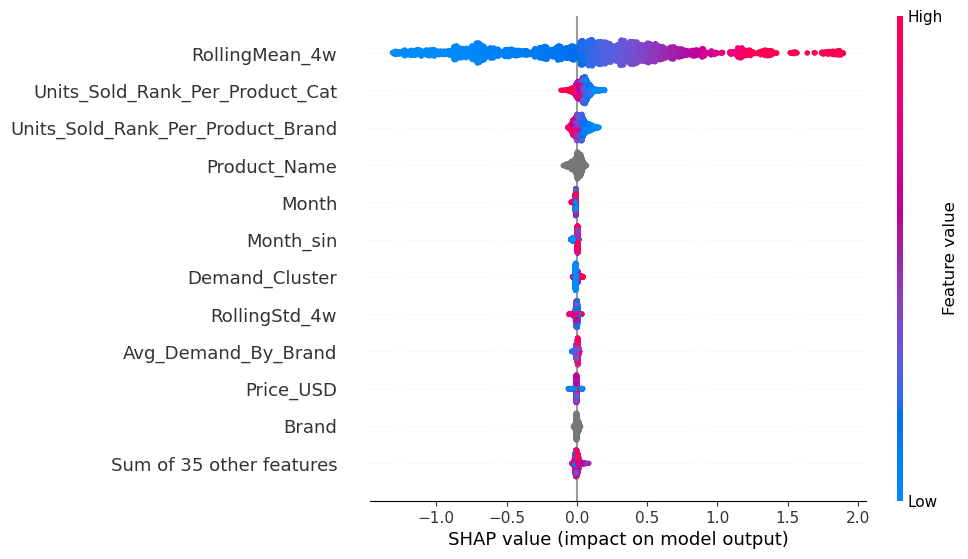

In [85]:
#Global Summary Plot (Top Features)
shap.plots.beeswarm(shap_values, max_display=12)

#### Light GBM Best Combined 

In [86]:
# Create X and y
id_cols = ['Pseudo_SKU_ID', 'Product_ID']
target_col = "Units_Sold_Log"
drop_cols = ['Units_Sold', 'Demand_Label', 'Date']
X_train_lgb_comb = train_encoded.copy().drop(columns=id_cols + [target_col] + drop_cols)
y_train_lgb_comb = train_encoded.copy()[target_col]

X_test_lgb_comb = test_encoded.copy().drop(columns=id_cols + [target_col] + drop_cols)
y_test_lgb_comb = test_encoded.copy()[target_col]

In [87]:
# Transforming cat_cols
cat_cols = ['Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage',
    'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']
for col in cat_cols:
    if col in X_train_lgb_comb.columns:
        X_train_lgb_comb[col] = X_train_lgb_comb[col].astype("category")
    if col in X_test_lgb_comb.columns:
        X_test_lgb_comb[col] = X_test_lgb_comb[col].astype("category")

In [88]:
# X_test_lgb_comb.to_parquet("../data/X_test_lgb_comb.parquet", index=False)

In [89]:
#Combine
#First removing n_estimator from random_search.best_params_ - avoiding conflict
params = random_search.best_params_.copy()
params.pop('n_estimators') 

lgb_model_comb = LGBMRegressor(
    **params,
    n_estimators=1000,  # Let early stopping decide actual depth
    subsample_freq=1,
    #reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1 
)

In [90]:
#Training
lgb_model_comb.fit(
    X_train_lgb_comb, y_train_lgb_comb,
    eval_set=[(X_test_lgb_comb, y_test_lgb_comb)],
    eval_metric='rmse',
    callbacks=[early_stopping(30), log_evaluation(10)]
)

Training until validation scores don't improve for 30 rounds
[10]	valid_0's rmse: 0.277309	valid_0's l2: 0.0769005
[20]	valid_0's rmse: 0.134328	valid_0's l2: 0.0180439
[30]	valid_0's rmse: 0.0951794	valid_0's l2: 0.00905912
[40]	valid_0's rmse: 0.0841007	valid_0's l2: 0.00707292
[50]	valid_0's rmse: 0.0797153	valid_0's l2: 0.00635453
[60]	valid_0's rmse: 0.0769494	valid_0's l2: 0.00592121
[70]	valid_0's rmse: 0.0771527	valid_0's l2: 0.00595253
[80]	valid_0's rmse: 0.0767408	valid_0's l2: 0.00588915
[90]	valid_0's rmse: 0.0767349	valid_0's l2: 0.00588824
[100]	valid_0's rmse: 0.0766363	valid_0's l2: 0.00587312
[110]	valid_0's rmse: 0.0764731	valid_0's l2: 0.00584814
[120]	valid_0's rmse: 0.076533	valid_0's l2: 0.00585731
[130]	valid_0's rmse: 0.0768064	valid_0's l2: 0.00589922
Early stopping, best iteration is:
[107]	valid_0's rmse: 0.0762836	valid_0's l2: 0.00581918


LGBMRegressor(max_depth=7, min_child_samples=30, n_estimators=1000, n_jobs=-1,
              num_leaves=63, random_state=42, reg_lambda=1.0, subsample=0.6,
              subsample_freq=1)

In [91]:
#Prediction
y_pred_train_lgb_comb = lgb_model_comb.predict(X_train_lgb_comb)
y_pred_test_lgb_comb = lgb_model_comb.predict(X_test_lgb_comb)

In [92]:
#Evaluating performance
evaluate_model(y_train_lgb_comb, y_pred_train_lgb_comb, "Train (lgb_comb)")
evaluate_model(y_test_lgb_comb, y_pred_test_lgb_comb, "Test (lgb_comb)")

Train (lgb_comb) RMSE: 0.0313
Train (lgb_comb) MAE:  0.0235
Train (lgb_comb) MAPE:  0.0058
Train (lgb_comb) R²:   0.9981

Test (lgb_comb) RMSE: 0.0763
Test (lgb_comb) MAE:  0.0615
Test (lgb_comb) MAPE:  0.0151
Test (lgb_comb) R²:   0.9888



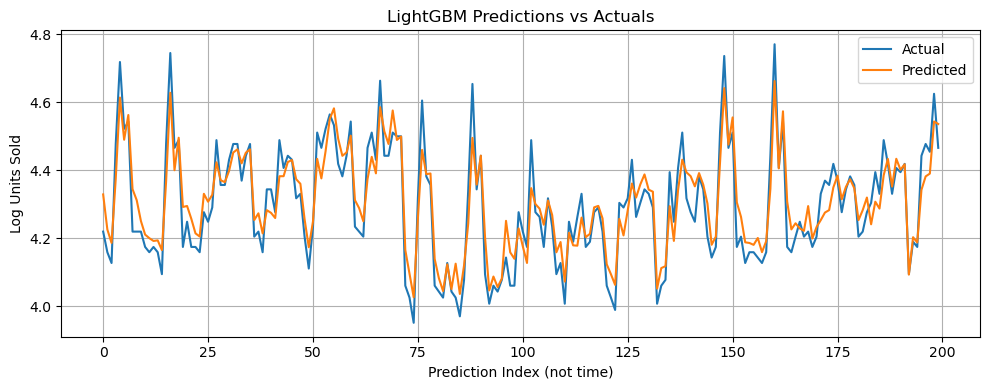

In [93]:
#Predictions vs actual
plt.figure(figsize=(10, 4))
plt.plot(y_test_lgb_comb.values[:200], label="Actual")
plt.plot(y_pred_test_lgb_comb[:200], label="Predicted")
plt.title("LightGBM Predictions vs Actuals")
plt.xlabel("Prediction Index (not time)")
plt.ylabel("Log Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### *Feature Importance*

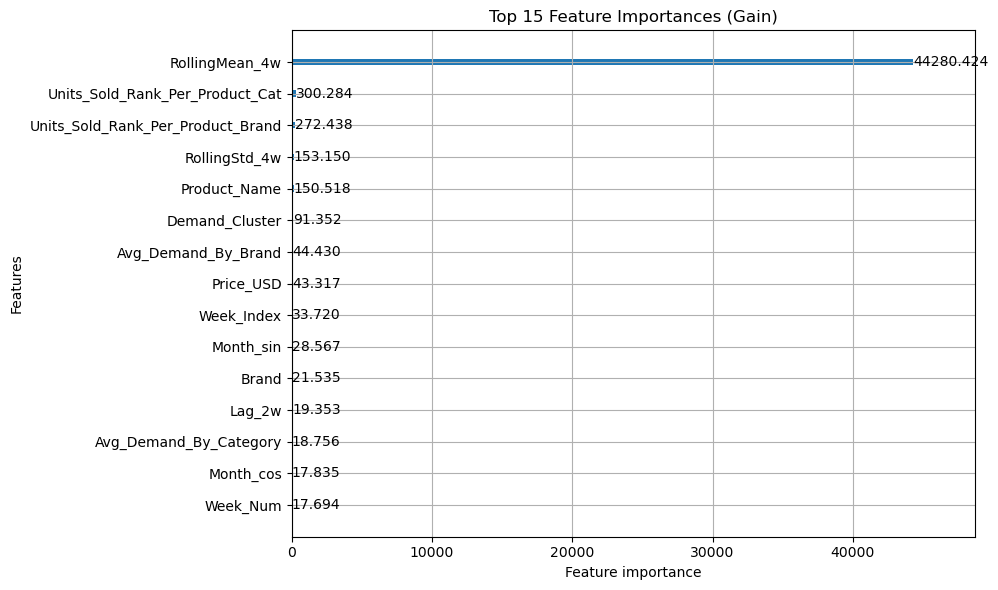

In [94]:
#Feature importance check

lgb.plot_importance(lgb_model_comb.booster_, max_num_features=15, importance_type="gain", figsize=(10, 6))
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

In [95]:
#Feature contribution to the prediction

# Building SHAP explainer from trained LightGBM model
explainer = shap.Explainer(lgb_model_comb)

# Computing SHAP values for the test set
shap_values = explainer(X_test_lgb_comb)

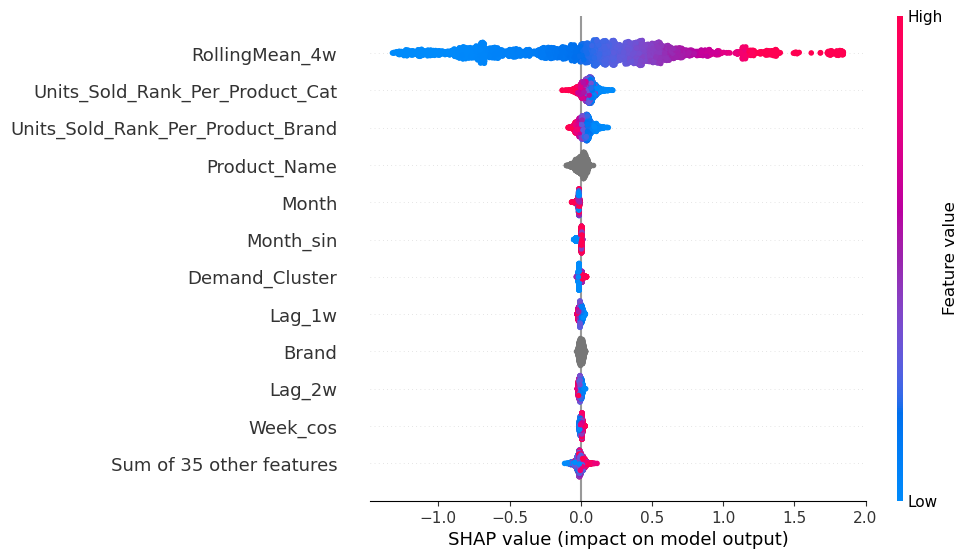

In [96]:
#Global Summary Plot (Top Features)
shap.plots.beeswarm(shap_values, max_display=12)

#### SUMMARY
                        LightGBM Model Comparison

| Model     | Train R² | Test R² | Train RMSE | Test RMSE | Overfitting? | Notes |
|-----------|----------|---------|------------|-----------|--------------|--------|
| lgb       | 0.9987   | 0.9887  | 0.0261     | 0.0765    | Moderate     | Extremely low train error, but generalizes better than expected. Slight overfit remains. |
| lgb_reg   | 0.9920   | 0.9827  | 0.0642     | 0.0948    | Minimal      | Regularization improved generalization with a slight drop in train fit. |
| lgb_rand  | 0.9963   | 0.9879  | 0.0437     | 0.0794    | Moderate     | Randomized tuning helped, but train error still too tight. Some overfit remains. |
| **lgb_comb**  | **0.9981**   | **0.9888**  | **0.0313**     | **0.0763**    | **Controlled**   | **Best balance overall — strong generalization with high train accuracy.** |


##### Saving the Model

In [97]:
#Saving the model and its features

# Save LightGBM model
joblib.dump(lgb_model_comb, "../models/lgb_comb_model.pkl")

# LightGBM’s native format (for inference/deployment)
lgb_model_comb.booster_.save_model("../models/lgb_comb_model.txt")

# Save the feature list
features_used = X_train_lgb_comb.columns.tolist()
import json
with open("../models/lgb_comb_features.json", "w") as f:
    json.dump(features_used, f)

## <span style="color:blue">III. MODELING WITH NEURAL NETWORK MODELS</span>

### LSTM (Long Short-Term Memory) as a Form of RNN (Recurrent Neural Network)

#### Final Preprocessing

In [98]:
num_cols_reduced = [
    'Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',
    'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',
    'Price_Promo_Interaction', 
    'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',
    'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',
   'Week_sin', 'Quarter_cos']

In [99]:
X_train_lstm = X_train_glm_ohe_vif.copy()
X_test_lstm = X_test_glm_ohe_vif.copy()
y_train = y_train_glm_original.copy()
y_test = y_test_glm_original.copy()

In [100]:
scaler = StandardScaler()
X_train_lstm[num_cols_reduced] = scaler.fit_transform(X_train_lstm[num_cols_reduced])

# Align to training columns
X_test_lstm = X_test_lstm.reindex(columns=X_train_lstm.columns, fill_value=0)

# Scale using final scaler
X_test_lstm[num_cols_reduced] = scaler.transform(X_test_lstm[num_cols_reduced])

In [101]:
# Used values
features_array = X_train_lstm.values
target_array = y_train.values 

In [102]:
# Sequence creation
def create_sequences(X, y, window=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

In [103]:
# Setting random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

#Set window size
window_size = 30

# Generate sequences
X_lstm_seq, y_lstm_seq = create_sequences(features_array, target_array, window=30)

# Train-test split
split = int(0.8 * len(X_lstm_seq))
X_train_lstm_seq, X_test_lstm_seq = X_lstm_seq[:split], X_lstm_seq[split:]
y_train_seq, y_test_seq = y_lstm_seq[:split], y_lstm_seq[split:]

#### Modeling

In [104]:
# Define input shape
input_shape = X_train_lstm_seq.shape[1:]

# Build and compile model# Setting random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

#Set window size
window_size = 30

# Generate sequences
X_lstm_seq, y_lstm_seq = create_sequences(features_array, target_array, window=30)

# Train-test split
split = int(0.8 * len(X_lstm_seq))
X_train_lstm_seq, X_test_lstm_seq = X_lstm_seq[:split], X_lstm_seq[split:]
y_train_seq, y_test_seq = y_lstm_seq[:split], y_lstm_seq[split:]
lstm_model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.1),
        LSTM(64),
        Dense(1, activation="linear")  
    ])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse'
)

# Training the model
lstm_model.fit(
    X_train_lstm_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    #callbacks=[] 
)

Epoch 1/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - loss: 1.9849 - val_loss: 0.0870
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - loss: 0.0293 - val_loss: 0.0772
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - loss: 0.0252 - val_loss: 0.0774
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - loss: 0.0231 - val_loss: 0.0776
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - loss: 0.0214 - val_loss: 0.0757
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - loss: 0.0208 - val_loss: 0.0754
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - loss: 0.0202 - val_loss: 0.0722
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - loss: 0.0196 - val_loss: 0.0720
Epoch 9/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - loss: 0.0189 - val_loss: 0.0713
Epoch 10/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - loss: 0.0182 - val_loss: 0.0683
Epoch 11/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 0.0180 - val_loss: 0.0702
Epoch 12/50
558/558 ━━━━━━━━━━

In [109]:
#Predict
predictions_train = lstm_model.predict(X_train_lstm_seq).flatten()
predictions_test = lstm_model.predict(X_test_lstm_seq).flatten()

697/697 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


#### Evaluation

In [110]:
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name="Model"):
    # Train metrics
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    print(f"{model_name} — Train Metrics")
    print(f"RMSE: {train_rmse:.4f}")
    print(f"MAE:  {train_mae:.4f}")
    print(f"MAPE: {train_mape:.4f}")
    print(f"R²:   {train_r2:.4f}\n")

    # Test metrics
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{model_name} — Test Metrics")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE:  {test_mae:.4f}")
    print(f"MAPE: {test_mape:.4f}")
    print(f"R²:   {test_r2:.4f}\n")

In [111]:
# Model with random seed:
evaluate_model(y_train_seq, predictions_train, y_test_seq, predictions_test, model_name="lstm")

lstm — Train Metrics
RMSE: 0.1532
MAE:  0.1006
MAPE: 0.0246
R²:   0.9480

lstm — Test Metrics
RMSE: 0.2006
MAE:  0.1564
MAPE: 0.0415
R²:   0.9479



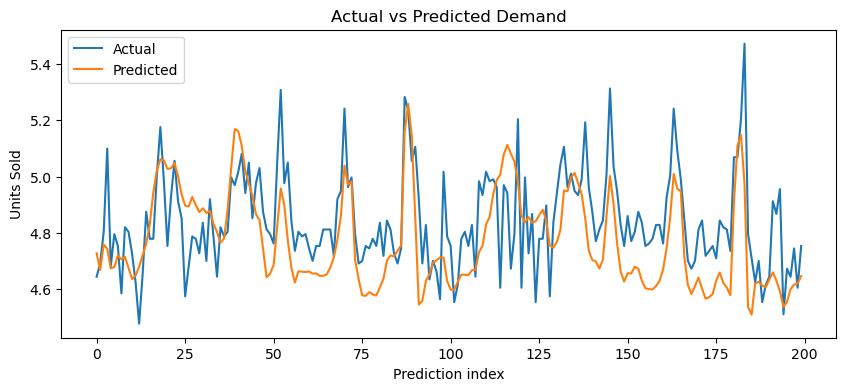

In [113]:
#Visually
plt.figure(figsize=(10, 4))
plt.plot(y_test_seq[:200], label="Actual")
plt.plot(predictions_test[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Demand")
plt.xlabel('Prediction index')
plt.ylabel("Units Sold")
plt.show()

### CNN (Convolutional Neural Network) Models

### *CNN - First Model*

#### Final Preprocessing

In [114]:
num_cols_reduced = [
    'Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',
    'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',
    'Price_Promo_Interaction', 
    'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',
    'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',
   'Week_sin', 'Quarter_cos']

In [115]:
# Copy and scale
X_train_cnn = X_train_glm_ohe_vif.copy()
X_test_cnn = X_test_glm_ohe_vif.copy()
y_train = y_train_glm_original.copy()
y_test = y_test_glm_original.copy()

scaler = StandardScaler()
X_train_cnn[num_cols_reduced] = scaler.fit_transform(X_train_cnn[num_cols_reduced])

# Align to training columns
X_test_cnn = X_test_cnn.reindex(columns=X_train_cnn.columns, fill_value=0)

# Scale using final scaler
X_test_cnn[num_cols_reduced] = scaler.transform(X_test_cnn[num_cols_reduced])

In [116]:
# Used values
features_array = X_train_cnn.values
target_array = y_train.values 

In [117]:
# Sequence creation
def create_sequences(X, y, window=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)
    
# Setting random seed
SEED = 7
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

#Set window size
window_size = 30

# Generate sequences
X_cnn_seq, y_cnn_seq = create_sequences(features_array, target_array, window=window_size)

In [118]:
# Train-test split
split = int(0.8 * len(X_cnn_seq))
X_train_cnn_seq, X_test_cnn_seq = X_cnn_seq[:split], X_cnn_seq[split:]
y_train_seq, y_test_seq = y_cnn_seq[:split], y_cnn_seq[split:]

#### Modeling

In [119]:
# Define input shape
input_shape = X_train_cnn_seq.shape[1:]  # (timesteps, features)
learning_rate = 0.0003

cnn_model = Sequential([
    Input(shape=input_shape),
    
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='causal'),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(32, kernel_size=3, activation='relu', padding='causal'),
    BatchNormalization(),
    Dropout(0.2),

    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='linear')  # predicting log-units-sold
])

cnn_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='mse'
)

In [120]:
cnn_model.fit(
    X_train_cnn_seq, y_train_seq,
    epochs=50,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 5.2116 - val_loss: 0.8677
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.8661 - val_loss: 0.2324
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.7046 - val_loss: 0.1534
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.6031 - val_loss: 0.1646
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.5204 - val_loss: 0.1434
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.4475 - val_loss: 0.1383
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.4170 - val_loss: 0.1464
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.3838 - val_loss: 0.1028
Epoch 9/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.3600 - val_loss: 0.1062
Epoch 10/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.3399 - val_loss: 0.1034
Epoch 11/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.3071 - val_loss: 0.1016
Epoch 12/50
558/558 ━━━━━━━━━━━━━━━━━━━━

In [121]:
# Predict 
predictions_train = cnn_model.predict(X_train_cnn_seq).flatten()
predictions_test = cnn_model.predict(X_test_cnn_seq).flatten()

697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


#### Evaluation

In [122]:
# Evaluate directly on log-transformed values
evaluate_model(y_train_seq, predictions_train, y_test_seq, predictions_test, model_name="cnn")

cnn — Train Metrics
RMSE: 0.1801
MAE:  0.1291
MAPE: 0.0322
R²:   0.9281

cnn — Test Metrics
RMSE: 0.2937
MAE:  0.2190
MAPE: 0.0560
R²:   0.8883



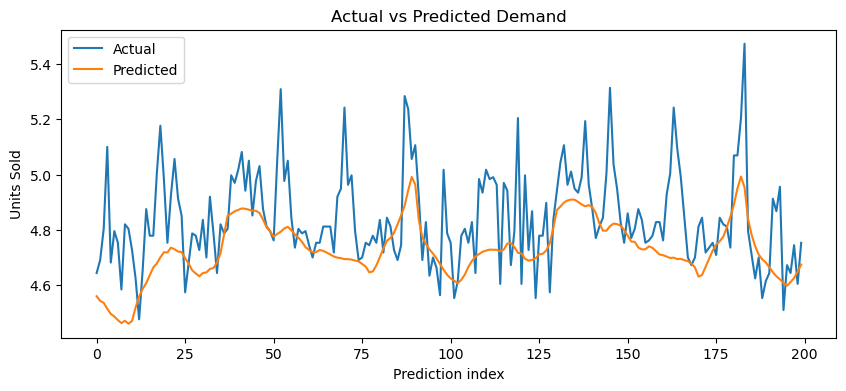

In [123]:
#Visually
plt.figure(figsize=(10, 4))
plt.plot(y_test_seq[:200], label="Actual")
plt.plot(predictions_test[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Demand")
plt.xlabel('Prediction index')
plt.ylabel("Units Sold")
plt.show()

### *CNN2 - Improved Architecture*

#### Modeling

In [127]:
X_train_cnn2_seq = X_train_cnn_seq.copy()
X_test_cnn2_seq = X_test_cnn_seq.copy()
y_train_seq2 = y_train_seq.copy()
y_test_seq2 = y_test_seq.copy()

In [128]:
# Define input shape
input_shape = X_train_cnn2_seq.shape[1:]  # (timesteps, features)
learning_rate = 0.0003

cnn2_model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, kernel_size=5, activation='relu', padding='causal'),
    BatchNormalization(),

    Conv1D(32, kernel_size=3, activation='relu', padding='causal'),
    BatchNormalization(),

    Conv1D(16, kernel_size=1, activation='relu', padding='causal'),
    BatchNormalization(),

    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='linear')
])

cnn2_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='huber'
)

In [129]:
# Training the model
history = cnn2_model.fit(
    X_train_cnn2_seq, y_train_seq2,
    epochs=50,
    validation_split=0.2,
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 2.0755 - val_loss: 0.7695
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3863 - val_loss: 0.3894
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.3119 - val_loss: 0.1368
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2641 - val_loss: 0.1113
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2361 - val_loss: 0.0849
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2080 - val_loss: 0.1038
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1937 - val_loss: 0.1278
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1802 - val_loss: 0.1155
Epoch 9/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1663 - val_loss: 0.1246
Epoch 10/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1443 - val_loss: 0.1178
Epoch 11/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1327 - val_loss: 0.2023
Epoch 12/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/ste

In [130]:
# Predict 
predictions_train = cnn2_model.predict(X_train_cnn2_seq).flatten()
predictions_test = cnn2_model.predict(X_test_cnn2_seq).flatten()

697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


#### Evaluation

In [131]:
# Model Evaluation
evaluate_model(y_train_seq2, predictions_train, y_test_seq2, predictions_test, model_name="cnn2")

cnn2 — Train Metrics
RMSE: 0.2088
MAE:  0.1409
MAPE: 0.0351
R²:   0.9034

cnn2 — Test Metrics
RMSE: 0.2916
MAE:  0.2295
MAPE: 0.0613
R²:   0.8899



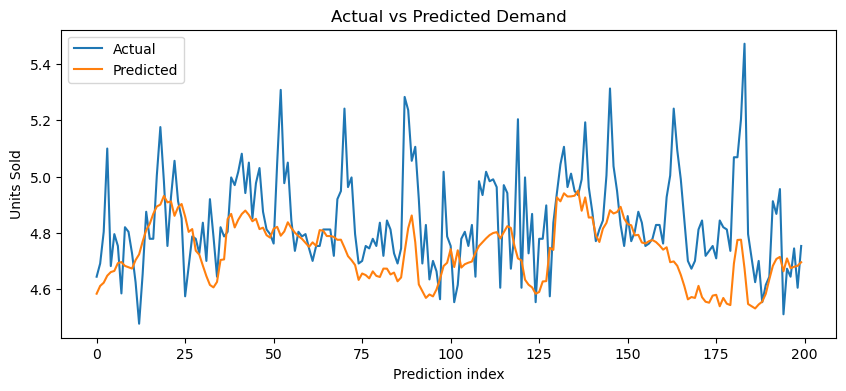

In [132]:
#Visually
plt.figure(figsize=(10, 4))
plt.plot(y_test_seq[:200], label="Actual")
plt.plot(predictions_test[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Demand")
plt.xlabel('Prediction index')
plt.ylabel("Units Sold")
plt.show()

### SUMMARY
                LSTM & CNN Model Comparison (Finalized)

| Model       | Train R² | Test R² | Test RMSE ↓ | Overfitting? | Notes |
|-------------|----------|---------|--------------|---------------|-------|
| **LSTM**    | 0.9480   | 0.9479  | 0.2006       | Minimal       | Balanced fit with strong generalization. Performs best among deep learning models. |
| **CNN**     | 0.9281   | 0.8883  | 0.2937       | Moderate      | Overfits more than LSTM. Lower performance overall. |
| **CNN (Tuned)** | 0.9034   | 0.8899  | 0.2916       | Lower         | Improved generalization vs. baseline CNN. Still underperforms traditional ML. |




Among the deep learning models, LSTM performed the best with a balanced fit and strong generalization. Tuning helped CNN improve.

### <span style="color:blue">Full Model Comparison – Train vs Test Performance</span>

| Model               | Train RMSE | Train R² | Test RMSE | Test R² | Notes |
|---------------------|------------|----------|-----------|---------|--------|
| **Naive**           | —          | —        | —         | —       | Simple baseline (last value), evaluated segment-wise only |
| **GLM**             | 0.1842     | 0.9345   | 0.2018    | 0.9216  | Basic interpretable model, limited in capturing complexity |
| **Ridge**           | 0.1516     | 0.9556   | 0.1732    | 0.9422  | Best among linear models |
| Lasso               | 0.1899     | 0.9303   | 0.2052    | 0.9188  | Slightly less accurate; prioritizes sparsity |
| ElasticNet          | 0.2005     | 0.9224   | 0.2150    | 0.9109  | Balanced regularization, weaker than Ridge |
| LightGBM            | 0.0261     | 0.9987   | 0.0765    | 0.9887  | Excellent fit, mild overfitting |
| LightGBM (Reg)      | 0.0642     | 0.9920   | 0.0948    | 0.9827  | Regularization improved generalization |
| LightGBM (Rand)     | 0.0437     | 0.9963   | 0.0794    | 0.9879  | Tuned with randomized search |
| **LightGBM (Comb)** | **0.0313** | **0.9981** | **0.0763** | **0.9888** | **Best overall — strong accuracy and generalization** |
| LSTM                | 0.1532     | 0.9480   | 0.2006    | 0.9479  | Decent deep learning baseline |
| CNN                 | 0.1801     | 0.9281   | 0.2937    | 0.8883  | Overfit and underfit combined, weak performance |
| CNN (Tuned)         | 0.2088     | 0.9034   | 0.2916    | 0.8899  | Improved balance, still behind ML models |


LightGBM clearly outperformed all other models, delivering the best mix of accuracy and generalization, especially after tuning. While deep learning models like LSTM and CNN were included for comparison, traditional ML worked better for this kind of structured data.

## <span style="color:blue">IV. SEGMENT-LEVEL MODEL PERFORMANCE</span>

### Preparation for Segment-level Evaluation

In [135]:
# Using best model (LightGBM combined) 
y_pred_test_lgb_comb_log = y_pred_test_lgb_comb
y_pred_test_lgb_comb_units = np.expm1(y_pred_test_lgb_comb_log)

# Attaching unit predictions to the test DataFrame
test_with_preds = test_encoded.copy()
test_with_preds["Pred_Units"] = y_pred_test_lgb_comb_units

# Evaluate per SKU
results = []
for sku_id, group in test_with_preds.groupby("Pseudo_SKU_ID"):
    y_true = np.expm1(group["Units_Sold_Log"]) 
    y_pred = group["Pred_Units"]                 
    if len(y_true) < 2:
        continue
        
    y_true_units = np.expm1(group["Units_Sold_Log"])
    y_pred_units = group["Pred_Units"]

    price = group["Price_USD"].mean()
    actual_revenue = y_true_units.sum() * price
    predicted_revenue = y_pred_units.sum() * price
    revenue_error = predicted_revenue - actual_revenue
    
    results.append({
    "Pseudo_SKU_ID": sku_id,
    "Region": group["Region"].iloc[0],
    "Channel": group["Channel"].iloc[0],
    "Brand": group["Brand"].iloc[0],
    "Test Rows": len(group),
    "RMSE": round(root_mean_squared_error(y_true_units, y_pred_units), 4),
    "MAE": round(mean_absolute_error(y_true_units, y_pred_units), 4),
    "MAPE": round(mean_absolute_percentage_error(y_true_units, y_pred_units), 4),
    "R²": round(r2_score(y_true_units, y_pred_units), 4),
    "Actual Units": int(y_true_units.sum()),
    "Predicted Units": int(y_pred_units.sum()),
    "Prediction Error (%)": round((y_pred_units.sum() - y_true_units.sum()) / y_true_units.sum() * 100, 1),
    "Price USD": round(price, 2),
    "Actual Revenue": round(actual_revenue, 2),
    "Predicted Revenue": round(predicted_revenue, 2),
    "Revenue Error": round(revenue_error, 2)
})

In [136]:
# Creating results DataFrame and sort by performance
results_df = pd.DataFrame(results).sort_values("R²", ascending=False)

# Calculating overall WMAPE and Accuracy
raw_df = pd.DataFrame(results)
total_abs_revenue_error = raw_df["Revenue Error"].abs().sum()
total_actual_revenue = raw_df["Actual Revenue"].sum()
wmape = total_abs_revenue_error / total_actual_revenue
accuracy = 1 - wmape

# Showing metrics
print(f"\n Overall WMAPE (Revenue-weighted): {wmape:.4f}")
print(f" Overall Forecast Accuracy:        {accuracy:.4f}")


 Overall WMAPE (Revenue-weighted): 0.0203
 Overall Forecast Accuracy:        0.9797


### Evaluation per Segments (SKU)

#### Best Segments

In [137]:
# Showing top-performing segments
results_df.head(10)

Pseudo_SKU_ID Region    Channel             Brand  Test Rows  \
162     34_China_Retail  China     Retail       Bobby Brown         12   
132      2_China_Retail  China     Retail   Danessa Myricks         12   
163  34_China_eCommerce  China  eCommerce       Bobby Brown         12   
72      20_China_Retail  China     Retail  Pat McGrath Labs         12   
181  37_China_eCommerce  China  eCommerce    Drunk Elephant         12   
180     37_China_Retail  China     Retail    Drunk Elephant         12   
133   2_China_eCommerce  China  eCommerce   Danessa Myricks         12   
108     26_China_Retail  China     Retail           Kiehl’s         12   
121  28_China_eCommerce  China  eCommerce   Danessa Myricks         12   
120     28_China_Retail  China     Retail   Danessa Myricks         12   

       RMSE     MAE    MAPE      R²  Actual Units  Predicted Units  \
162  4.2715  3.8040  0.0389  0.9590          1225             1246   
132  4.7801  4.0306  0.0419  0.9537          1266             1300   
163  5.6662  4.5843  0.0449  0.9449          1223             1239   
72   2.7721  2.3213  0.0411  0.9440           674              679   
181  5.8152  4.8168  0.0508  0.9332          1194             1210   
180  6.6606  4.6964  0.0517  0.9322          1209             1230   
133  5.7156  4.5380  0.0456  0.9284          1297             1325   
108  6.9532  6.0827  0.0541  0.9234          1344             1380   
121  5.7196  4.7000  0.0552  0.9194          1099             1122   
120  6.0825  5.1754  0.0572  0.9124          1151             1191   

     Prediction Error (%)  Price USD  Actual Revenue  Predicted Revenue  \
162                   1.7     108.86       133353.50          135641.42   
132                   2.7      78.71        99646.86          102339.84   
163                   1.3     108.86       133135.78          134897.84   
72                    0.9      95.82        64582.68           65149.30   
181                   1.4      52.38        62541.72           63407.61   
180                   1.8      52.38        63327.42           64442.48   
133                   2.2      78.71       102086.87          104310.76   
108                   2.7      98.80       132787.20          136396.33   
121                   2.1      61.48        67566.52           69017.34   
120                   3.5      61.48        70763.48           73257.96   

     Revenue Error  
162        2287.92  
132        2692.98  
163        1762.06  
72          566.62  
181         865.89  
180        1115.06  
133        2223.89  
108        3609.13  
121        1450.82  
120        2494.48

#### Worst Segments

In [138]:
# Checking for Outliers (Bad Segments Hidden by Average)

# Load raw numeric results (no formatting issues)
results_df_numeric = pd.DataFrame(results)

# Add absolute Prediction Error (%)
results_df_numeric["Abs Prediction Error (%)"] = results_df_numeric["Prediction Error (%)"].abs()

# Find worst segments by signed revenue error
worst_segments = results_df_numeric.sort_values(by="Revenue Error", key=abs, ascending=False)

# Show top 10 worst by revenue error
print("Top 10 Worst Segments by Revenue Error:")
display(worst_segments.head(10))

Top 10 Worst Segments by Revenue Error:


Pseudo_SKU_ID Region    Channel               Brand  Test Rows  \
299      9_US_eCommerce     US  eCommerce  Yves Saint Laurent         12   
157  33_China_eCommerce  China  eCommerce         Bobby Brown         12   
22         12_US_Retail     US     Retail  Yves Saint Laurent         12   
54      18_China_Retail  China     Retail             Kiehl’s         12   
155     32_US_eCommerce     US  eCommerce    Make Up For Ever         12   
263     49_US_eCommerce     US  eCommerce     Kylie Cosmetics         12   
259  49_China_eCommerce  China  eCommerce     Kylie Cosmetics         12   
298         9_US_Retail     US     Retail  Yves Saint Laurent         12   
19   12_China_eCommerce  China  eCommerce  Yves Saint Laurent         12   
23      12_US_eCommerce     US  eCommerce  Yves Saint Laurent         12   

       RMSE     MAE    MAPE      R²  Actual Units  Predicted Units  \
299  8.2222  7.3256  0.0841  0.5207          1060             1107   
157  5.3672  4.6501  0.1465  0.4815           388              426   
22   6.1778  5.3392  0.0682  0.6917           958              993   
54   8.7570  7.6769  0.1167  0.6565           810              866   
155  6.3234  6.0038  0.1114  0.0645           661              701   
263  3.8590  3.3107  0.1013  0.0528           412              450   
259  4.2174  3.5514  0.1191  0.6275           383              417   
298  7.9119  7.4684  0.0890  0.6238          1026             1062   
19   8.8852  7.4251  0.1037  0.7144           850              879   
23   5.9732  5.1942  0.0698  0.7283           936              964   

     Prediction Error (%)  Price USD  Actual Revenue  Predicted Revenue  \
299                   4.5     119.66       126839.60          132531.58   
157                   9.9     145.38        56407.44           61982.93   
22                    3.7     148.28       142052.24          147346.75   
54                    7.0      92.03        74544.30           79754.95   
155                   6.1     129.07        85315.27           90520.15   
263                   9.4     128.98        53139.76           58117.08   
259                   9.1     128.98        49399.34           53898.93   
298                   3.6     119.66       122771.16          127194.57   
19                    3.4     148.28       126038.00          130369.61   
23                    3.0     148.28       138790.08          143012.46   

     Revenue Error  Abs Prediction Error (%)  
299        5691.98                       4.5  
157        5575.49                       9.9  
22         5294.51                       3.7  
54         5210.65                       7.0  
155        5204.88                       6.1  
263        4977.32                       9.4  
259        4499.59                       9.1  
298        4423.41                       3.6  
19         4331.61                       3.4  
23         4222.38                       3.0

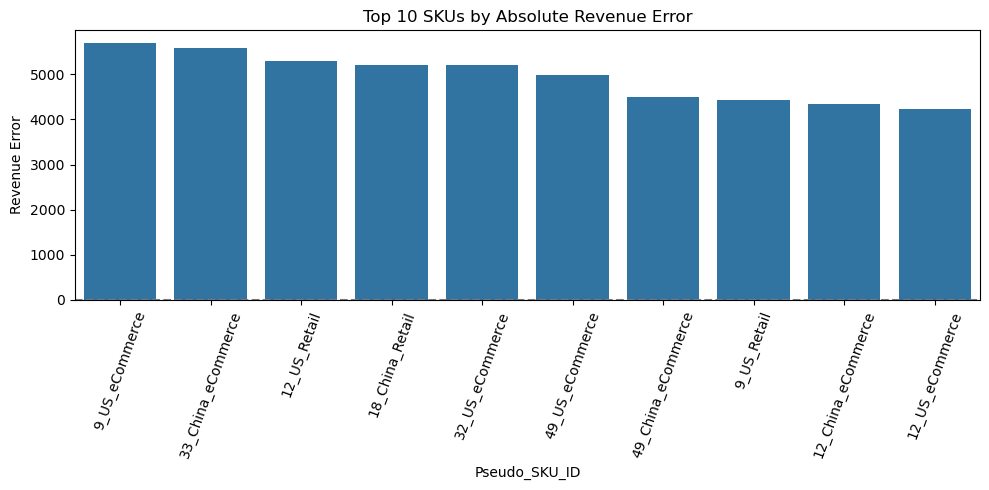

In [139]:
results_df_sorted = results_df.sort_values("R²", ascending=False)
top_errors = results_df_sorted.sort_values("Revenue Error", key=abs, ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x="Pseudo_SKU_ID", y="Revenue Error", data=top_errors)
plt.xticks(rotation=70)
plt.title("Top 10 SKUs by Absolute Revenue Error")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

#### Examining Forecast Quality Across Volume and Segments

##### Forecast Accuracy by Sales Volume

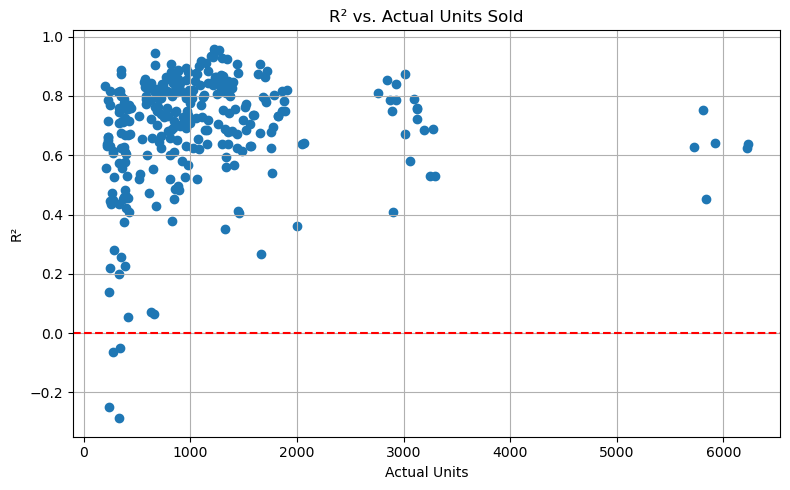

In [140]:
# R² vs. Volume
plt.figure(figsize=(8, 5))
plt.scatter(results_df["Actual Units"], results_df["R²"])
plt.axhline(0, color="red", linestyle="--")
plt.title("R² vs. Actual Units Sold")
plt.xlabel("Actual Units")
plt.ylabel("R²")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Forecast Error by Sales Volume

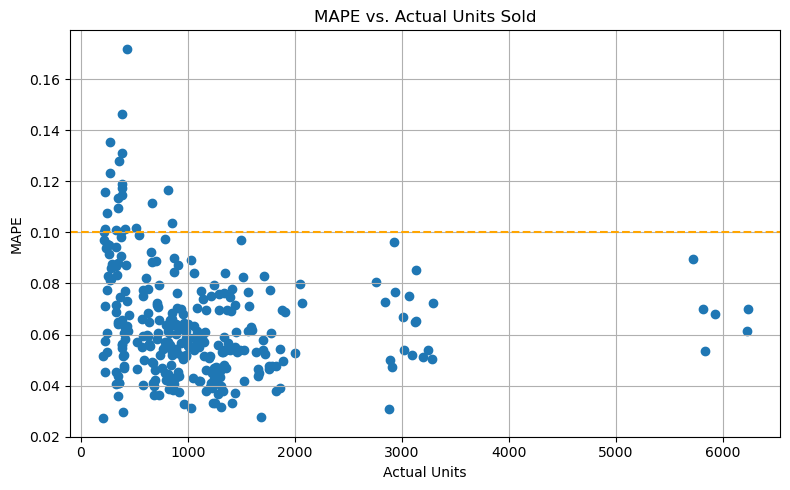

In [141]:
#MAPE vs. Volume
plt.figure(figsize=(8, 5))
plt.scatter(results_df["Actual Units"], results_df["MAPE"])
plt.axhline(0.10, color="orange", linestyle="--", label="10% Threshold")
plt.title("MAPE vs. Actual Units Sold")
plt.xlabel("Actual Units")
plt.ylabel("MAPE")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Forecast Accuracy by Deamnd Cluster

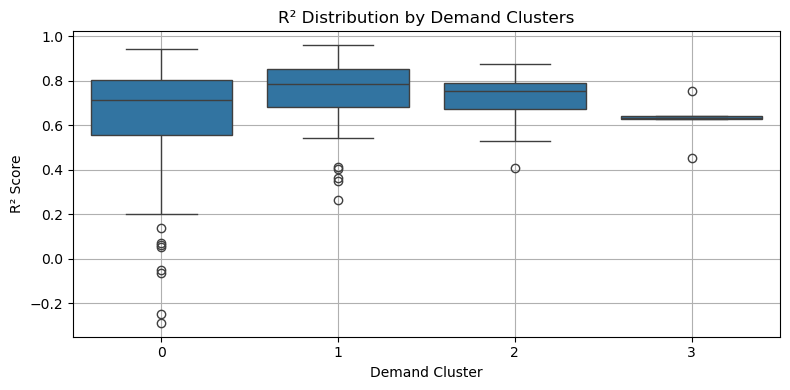

In [142]:
# R² Distribution by Demand Clusters
results_df = results_df.merge(
    train_encoded[['Pseudo_SKU_ID', 'Demand_Cluster']].drop_duplicates(),
    on='Pseudo_SKU_ID',
    how='left'
)
plt.figure(figsize=(8, 4))
sns.boxplot(data=results_df, x='Demand_Cluster', y='R²')

plt.title("R² Distribution by Demand Clusters")
plt.xlabel("Demand Cluster")
plt.ylabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Overall Forecast Quality Ranking

In [143]:
# Define Composite Indicator (R², MAPE, Volume Scores)
def r2_score_band(r2):
    if r2 >= 0.6: return 3  # Strong model
    elif r2 >= 0.3: return 2  # Moderate
    elif r2 >= 0.1: return 1  # Weak, but not useless
    else: return 0  # No explanatory power

def mape_score_band(mape):
    if mape <= 0.10: return 3  # Excellent
    elif mape <= 0.20: return 2  # Good
    elif mape <= 0.40: return 1  # Acceptable
    else: return 0  # Poor

def volume_score_band(units):
    if units >= 1000: return 3
    elif units >= 500: return 2
    elif units >= 100: return 1
    else: return 0

In [144]:
# Apply the bands and compute composite score

results_df["R2_Score"] = results_df["R²"].apply(r2_score_band)
results_df["MAPE_Score"] = results_df["MAPE"].apply(mape_score_band)
results_df["Volume_Score"] = results_df["Actual Units"].apply(volume_score_band)

# Final score out of 9
results_df["Forecast_Quality_Score"] = (
    results_df["R2_Score"] +
    results_df["MAPE_Score"] +
    results_df["Volume_Score"]
)

In [145]:
# Define interpretation categories
def quality_label(score):
    if score >= 7: return "Excellent"
    elif score >= 5: return "Good"
    elif score >= 3: return "Weak"
    else: return "Poor"

results_df["Forecast_Quality_Label"] = results_df["Forecast_Quality_Score"].apply(quality_label)

In [146]:
# Example summary view
results_df.groupby(["Demand_Cluster", "Forecast_Quality_Label"]).size()

Demand_Cluster  Forecast_Quality_Label
0               Excellent                 129
                Good                       36
                Weak                        7
1               Excellent                 104
2               Excellent                  18
3               Excellent                   6
dtype: int64

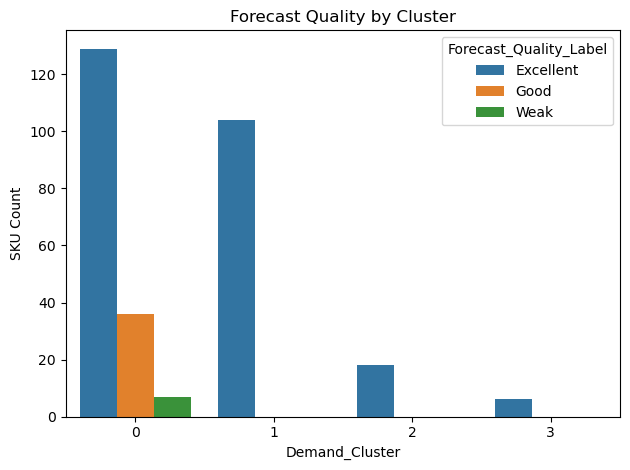

In [147]:
sns.countplot(data=results_df, x="Demand_Cluster", hue="Forecast_Quality_Label")
plt.title("Forecast Quality by Cluster")
plt.ylabel("SKU Count")
plt.tight_layout()
plt.show()

Demand Clusters:  
            0: "Low Demand / Stable",   
            1: "Medium Demand / Stable",  
            2: "High Demand / Volatile",  
            3: "Very High Demand / Highly Volatile"  

#### Author  
*Eszter Varga – Data Scientist*  
*GitHub: Timensider*  

*Worked through this project independently, collaborating with AI tools and documentation along the way — just as I would in a real-world workflow.*